In [119]:
# Importar librerías

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import pprint
import plotly.express as px


# **Lectura de datos**

In [2]:
#extraer los datos
url = 'https://raw.githubusercontent.com/SantiRestrepoOlarte/Trabajo2_Analitica_2/main/ObesityDataSet_raw_and_data_sinthetic.csv'

df_obesidad = pd.read_csv(url)

In [3]:
# Realizar una copia de los datos

df_obesidad_copy = df_obesidad

# **Análisis exploratorio**

In [4]:
# visualizar los datos
df_obesidad.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight


In [5]:
# Renombramiento de columnas

df_obesidad.rename(columns={"Gender":"GENERO","Age":"EDAD","Height":"ALTURA","Weight":"PESO","family_history_with_overweight":"HISTORIAL_FAMILIAR","FAVC":"ALIMENTOS_CALORIAS","FCVC":"FRECUENCIA_VERDURAS","NCP":"COMIDAS_PRINCIPALES","CAEC":"ENTRE_COMIDAS","SMOKE":"FUMADOR","CH2O":"AGUA_DIARIA","SCC":"MONITOREA_CALORIAS","FAF":"ACTIVIDAD_FISICA","TUE":"TIEMPO_DISPOSITIVOS","CALC":"FRECUENCIA_ALCOHOL","MTRANS":"MEDIO_TRANSPORTE","NObeyesdad":"NIVEL_OBESIDAD"},inplace=True)


In [6]:
# Eliminación de variable objetivo

df_obesidad = df_obesidad.drop('NIVEL_OBESIDAD', axis=1)

In [7]:
df_obesidad.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation


In [8]:
#dimensión del dataset

df_obesidad.shape

(2111, 16)

In [9]:
df_obesidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GENERO               2111 non-null   object 
 1   EDAD                 2111 non-null   float64
 2   ALTURA               2111 non-null   float64
 3   PESO                 2111 non-null   float64
 4   HISTORIAL_FAMILIAR   2111 non-null   object 
 5   ALIMENTOS_CALORIAS   2111 non-null   object 
 6   FRECUENCIA_VERDURAS  2111 non-null   float64
 7   COMIDAS_PRINCIPALES  2111 non-null   float64
 8   ENTRE_COMIDAS        2111 non-null   object 
 9   FUMADOR              2111 non-null   object 
 10  AGUA_DIARIA          2111 non-null   float64
 11  MONITOREA_CALORIAS   2111 non-null   object 
 12  ACTIVIDAD_FISICA     2111 non-null   float64
 13  TIEMPO_DISPOSITIVOS  2111 non-null   float64
 14  FRECUENCIA_ALCOHOL   2111 non-null   object 
 15  MEDIO_TRANSPORTE     2111 non-null   o

In [10]:
df_obesidad.describe()

,EDAD,ALTURA,PESO,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


Al analizar los datos numericos de la tabla podemos observar que la variable EDAD se comporta con normalidad, además la variable ALTURA se supone que está en metros y PESO está en kilos. Tambien se puede observar que la varible FRECUENCIA_VERDURAS es el número de veces que una persona incluye verduras en una de sus comidas al día y COMIDAS_PRINCIPALES es el número de comidas principales que consume una persona al día.

De ahí, se puede observar que los datos numéricos no parecen presentar datos atípicos o extremos que puedan llegar a afectar el desarrollo del proyecto, además, no se evidencian datos nulos o faltantes.

## **Datos faltantes** 

In [11]:
df_obesidad.isnull().sum()

GENERO                 0
EDAD                   0
ALTURA                 0
PESO                   0
HISTORIAL_FAMILIAR     0
ALIMENTOS_CALORIAS     0
FRECUENCIA_VERDURAS    0
COMIDAS_PRINCIPALES    0
ENTRE_COMIDAS          0
FUMADOR                0
AGUA_DIARIA            0
MONITOREA_CALORIAS     0
ACTIVIDAD_FISICA       0
TIEMPO_DISPOSITIVOS    0
FRECUENCIA_ALCOHOL     0
MEDIO_TRANSPORTE       0
dtype: int64

In [12]:
df_obesidad.head()

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


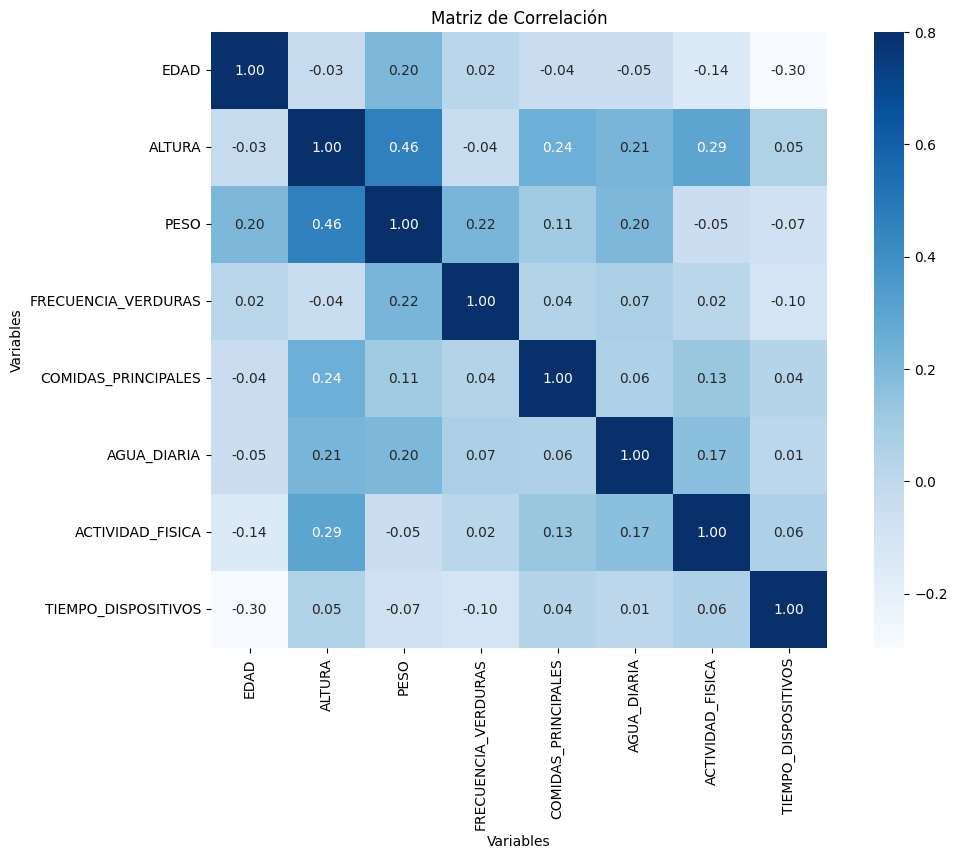

In [13]:
#Matriz de correlación 

# Seleccionar columnas numéricas
columnas_numericas = [col for col in df_obesidad.columns if df_obesidad[col].dtype != 'object']

# Filtrar DataFrame a las variables numéricas
df_numerico = df_obesidad[columnas_numericas]

# Calcular la matriz de correlación
corrmat = df_numerico.corr()

# Configurar tamaño de la figura
f, ax = plt.subplots(figsize=(12, 8))

# Mostrar la matriz de correlación como mapa de calor
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, annot_kws={"fontsize": 10}, fmt=".2f", cmap='Blues')

# Agregar título y etiquetas
plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Mostrar la figura
plt.show()


De la matriz de correlación podemos observar que se presenta una correlación positiva entre el peso y la altura (relación que es de esperarse), sin embargo no presenta un valor de considerable, por ende se decide mantener las variables que posee el dataset.

### **Exploración de variables**

In [14]:
# Columna 'GENERO'
df_obesidad['GENERO'].describe()
df_obesidad['GENERO'].value_counts()

GENERO
Male      1068
Female    1043
Name: count, dtype: int64

Al analizar la variable *'GENERO'* podemos ver que cuenta con un número de observaciones similar entre hombres (50.6%) y mujeres (49.4%).


In [15]:
# Columna 'HISTORIAL_FAMILIAR'
df_obesidad['HISTORIAL_FAMILIAR'].describe()
df_obesidad['HISTORIAL_FAMILIAR'].value_counts()

HISTORIAL_FAMILIAR
yes    1726
no      385
Name: count, dtype: int64

Se puede apreciar que el 81.76% de las personas del estudio posee antecedentes familiares por obesidad.

In [16]:
# Columna 'ALIMENTOS_CALORIAS' ALIMENTOS ALTOS EN CALORIAS
df_obesidad['ALIMENTOS_CALORIAS'].describe()
df_obesidad['ALIMENTOS_CALORIAS'].value_counts()

ALIMENTOS_CALORIAS
yes    1866
no      245
Name: count, dtype: int64

In [17]:
# Columna 'FECUENCIA_VERDURAS' 
df_obesidad['FRECUENCIA_VERDURAS'].describe()	
df_obesidad['FRECUENCIA_VERDURAS'].value_counts()

FRECUENCIA_VERDURAS
3.000000    652
2.000000    600
1.000000     33
2.823179      2
2.214980      2
           ... 
2.927409      1
2.706134      1
2.010684      1
2.300408      1
2.680375      1
Name: count, Length: 810, dtype: int64

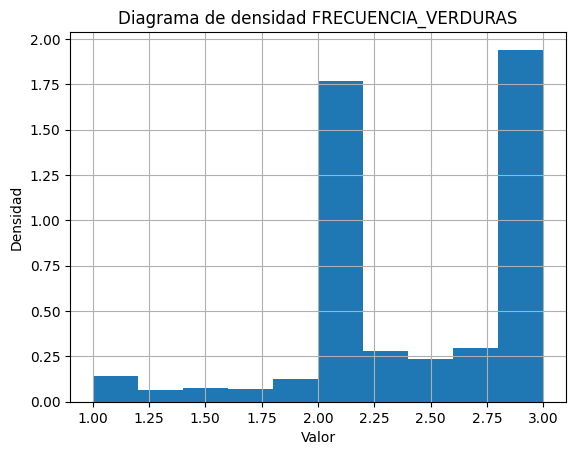

In [18]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['FRECUENCIA_VERDURAS'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad FRECUENCIA_VERDURAS')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Para el caso de la variable *''FRECUENCIA_VERDURAS* se observa que la mayoría de los valores se concentran en los valores enteros (1,2 y 3). Sin embargo, se decide mantener los valores decimales dentro de esta columna dado que puede ofrecer explicabilidad al modelo.

In [19]:
#COLUMNA COMIDAS_PRINCIPALES	
df_obesidad['COMIDAS_PRINCIPALES'].describe()
df_obesidad['COMIDAS_PRINCIPALES'].value_counts()

COMIDAS_PRINCIPALES
3.000000    1203
1.000000     199
4.000000      69
2.776840       2
3.985442       2
            ... 
3.054899       1
3.118013       1
3.335876       1
3.205009       1
1.089048       1
Name: count, Length: 635, dtype: int64

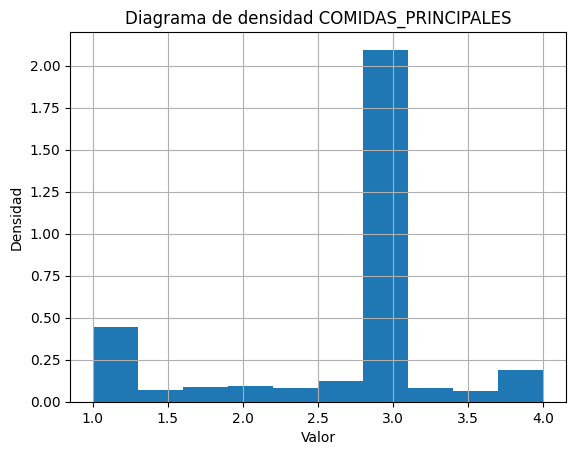

In [20]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['COMIDAS_PRINCIPALES'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad COMIDAS_PRINCIPALES')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Para el caso de *'COMIDAS_PRINCIPALES'* se podría llevar a cabo el mismo procedimiento que para *'FRECUENCIA_VERDURAS'*.

In [21]:
#COLUMA ENTRE_COMIDAS

df_obesidad['ENTRE_COMIDAS'].describe()
df_obesidad['ENTRE_COMIDAS'].value_counts()


ENTRE_COMIDAS
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

En el caso de la variable *'ENTRE_COMIDAS'* se observa que es una variable categórica ordinal que sólo posee 4 clases, por ende, sería conveniente convertirla a numérica de acuerdo al orden de la variable. Por ejemplo, para la clase *'no'* se puede reemplazar por 0, *'Sometimes'* por 1, *'Frequently'* por 2 y finalmente, *'Always'* por 3 de modo que se mantenga el orden y el peso de las categorias.

In [22]:
#COLUMNA FUMADOR 

df_obesidad['FUMADOR'].describe()
df_obesidad['FUMADOR'].value_counts()


FUMADOR
no     2067
yes      44
Name: count, dtype: int64

De la variable *'FUMADOR'* se puede observar que la mayor parte de la población del estudio no son fumadores, solamente fuman el 2.08% de ellas. Ahora, se observa que esta variable se encuentra clasificada como 'yes' y 'no' por lo que para variables de este estilo se puede reemplazar 'yes' por 1 y 'no' por 0 de modo que sean numéricas. Sin embargo esta variable es candidata a ser eliminada por la poca explicabilidad que ofrece.


In [23]:
#COLUMNA AGUA_DIARIA	
df_obesidad['AGUA_DIARIA'].describe()
df_obesidad['AGUA_DIARIA'].value_counts()

AGUA_DIARIA
2.000000    448
1.000000    211
3.000000    162
2.825629      3
1.636326      3
           ... 
1.622638      1
2.452986      1
2.035954      1
1.944095      1
2.863513      1
Name: count, Length: 1268, dtype: int64

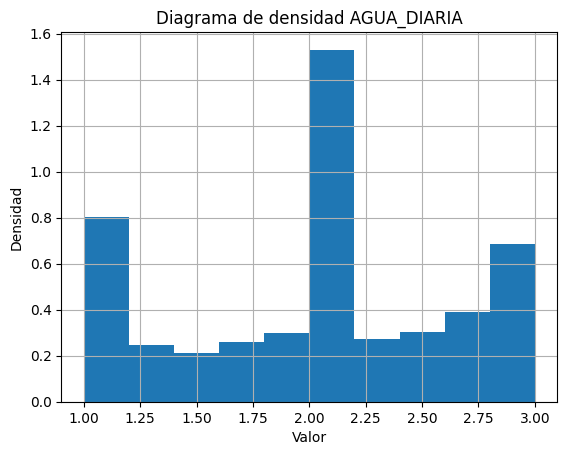

In [24]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['AGUA_DIARIA'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad AGUA_DIARIA')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [25]:
# COLUMNA MONITOREA_CALORIAS	
df_obesidad['MONITOREA_CALORIAS'].describe()
df_obesidad['MONITOREA_CALORIAS'].value_counts()

MONITOREA_CALORIAS
no     2015
yes      96
Name: count, dtype: int64

Se puede apreciar que en la columna *'MONITOREA_CALORIAS'* el 95.45% de las personas no está al tanto de cuantas calorias consume al día por lo que esto puede ser un indicador de que las personas no se preocupan por la cantidad de calorias que consumen en un día. Dado el desbalanceo de esta variable puede ser candidata a ser eliminada del dataset.

In [26]:
#COLUMNA ACTIVIDAD_FISICA	
df_obesidad['ACTIVIDAD_FISICA'].describe()
df_obesidad['ACTIVIDAD_FISICA'].value_counts()

ACTIVIDAD_FISICA
0.000000    411
1.000000    234
2.000000    183
3.000000     75
0.110174      2
           ... 
1.916751      1
0.954459      1
0.340915      1
0.986414      1
1.026452      1
Name: count, Length: 1190, dtype: int64

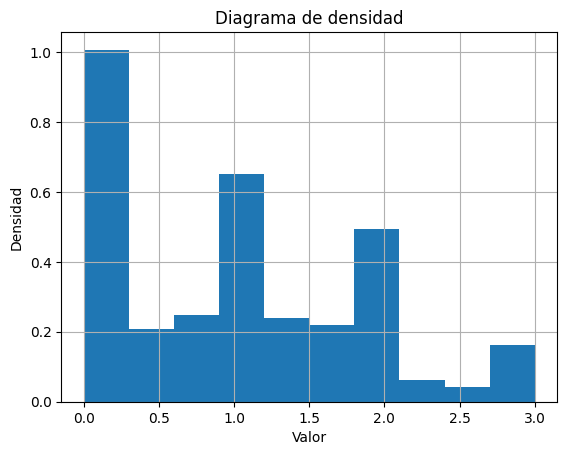

In [20]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['ACTIVIDAD_FISICA'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad ACTIVIDAD_FISICA')
plt.grid(True)

# Mostrar el gráfico
plt.show()

En el caso de la variable *'ACTIVIDAD_FISICA'* se observa una tendencia decreciente en la cual gran parte de las personas implicadas en el estudio no realiza actividad física durante el día y pocas de ellas lo hacen 3 veces al día.

In [27]:
#COLUMNA TIEMPO_DISPOSITIVOS

df_obesidad['TIEMPO_DISPOSITIVOS'].describe()
df_obesidad['TIEMPO_DISPOSITIVOS'].value_counts()

TIEMPO_DISPOSITIVOS
0.000000    557
1.000000    292
2.000000    109
0.630866      4
1.119877      3
           ... 
1.343044      1
1.019452      1
0.673408      1
0.997600      1
0.714137      1
Name: count, Length: 1129, dtype: int64

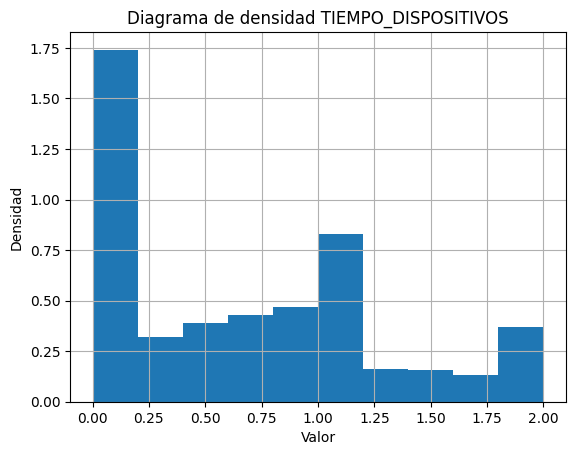

In [11]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['TIEMPO_DISPOSITIVOS'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad TIEMPO_DISPOSITIVOS')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Se observa que gran parte de las personas del estudio no pasan tiempo al frente de dispositivos tecnológicos manteniendo una tendencia decreciente en la cual son pocas las personas que pasan más de 1 hora al frente de estos.

In [28]:
#COLUMNA FRECUENCIA_ALCOHOL	

df_obesidad['FRECUENCIA_ALCOHOL'].describe()
df_obesidad['FRECUENCIA_ALCOHOL'].value_counts()


FRECUENCIA_ALCOHOL
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

En la columna *'FRECUENCIA_ALCOHOL'* encontramos que el 66.37% de las personas consume alcohol a veces, lo que es un porcentaje alto en las personas del estudio. Esta variable puede ser de importancia, y además, se convertirá a numérica como en el caso de *'ENTRE_COMIDAS'*.

In [29]:
#COLUMNA MEDIO_TRANSPORTE

df_obesidad['MEDIO_TRANSPORTE'].describe()
df_obesidad['MEDIO_TRANSPORTE'].value_counts()

MEDIO_TRANSPORTE
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

Muy pocas personas utilizan medios de transporte en donde tengan que realizar un esfuerzo físico para llegar a sus destinos, ya que sólo el 2.98% de las personas caminan. 

Para el tratamiento de esta variable se decide agrupar las personas que no realizan un esfuerzo físico para desplazarse (Motorbike, Automobile y Public_Transportation), las cuales se reemplazan por el valor de 0. Así mismo, se agrupan las personas que realiza un esfuerzo físico para desplazarse (Bike y Walking), las cuales se reemplazan por 1.

## **Datos duplicados**

In [30]:
# Identificar filas duplicadas
filas_duplicadas = df_obesidad.duplicated()

# Contar el número de filas duplicadas
cantidad_duplicados = filas_duplicadas.sum()
cantidad_duplicados

# Mostrar las filas duplicadas
df_obesidad[filas_duplicadas]


,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
98,Female,21.0,1.52,42.0,no,no,3.0,1.0,Frequently,no,1.0,no,0.0,0.0,Sometimes,Public_Transportation
106,Female,25.0,1.57,55.0,no,yes,2.0,1.0,Sometimes,no,2.0,no,2.0,0.0,Sometimes,Public_Transportation
174,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation
179,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation
184,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation
209,Female,22.0,1.69,65.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation
309,Female,16.0,1.66,58.0,no,no,2.0,1.0,Sometimes,no,1.0,no,0.0,1.0,no,Walking
460,Female,18.0,1.62,55.0,yes,yes,2.0,3.0,Frequently,no,1.0,no,1.0,1.0,no,Public_Transportation
467,Male,22.0,1.74,75.0,yes,yes,3.0,3.0,Frequently,no,1.0,no,1.0,0.0,no,Automobile
496,Male,18.0,1.72,53.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,2.0,Sometimes,Public_Transportation


In [31]:
print("Número de filas duplicadas:", cantidad_duplicados)

Número de filas duplicadas: 24


Se observa que el dataset posee 24 observaciones duplicadas, las cuales se proceden a eliminar.

In [32]:
#Eliminar filas duplicadas

df_obesidad = df_obesidad.drop_duplicates()

In [33]:
df_obesidad.shape

(2087, 16)

# **Análisis univariado**

In [34]:
variables = ['EDAD', 'ALTURA', 'PESO']
variables2 = ['FRECUENCIA_VERDURAS', 'COMIDAS_PRINCIPALES', 'AGUA_DIARIA']
variables3 = ['ACTIVIDAD_FISICA', 'TIEMPO_DISPOSITIVOS','PESO']


In [35]:
def graficar_boxplots_3(df, variables):
  # Seleccionar las variables
  df_subset = df[variables]

  # Graficar boxplots
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  for i, variable in enumerate(variables):
    sns.boxplot(data=df_subset[variable], ax=axes[i])
    axes[i].set_title(variable)

  # Ajustar la figura
  plt.tight_layout()
  plt.show()

def graficar_boxplots_4(df, variables):
  # Seleccionar las variables
  df_subset = df[variables]

  # Graficar boxplots
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  for i, variable in enumerate(variables):
    sns.boxplot(data=df_subset[variable], ax=axes[i])
    axes[i].set_title(variable)

  # Ajustar la figura
  plt.tight_layout()
  plt.show()

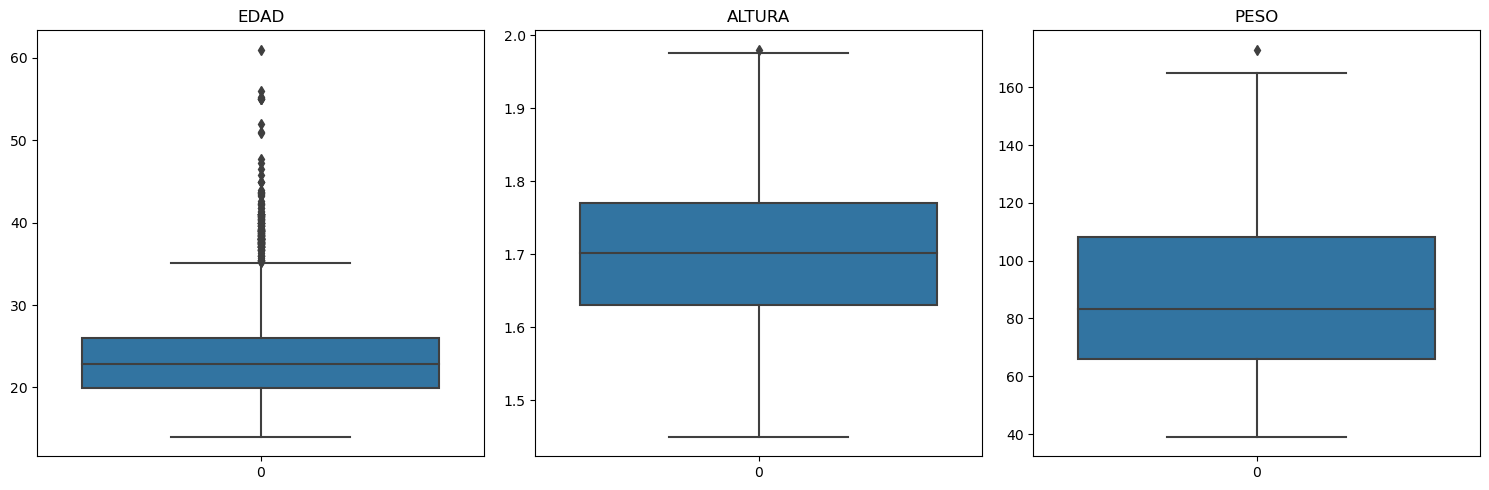

In [26]:
graficar_boxplots_4(df_obesidad, variables)

**Edad:** La distribución de la edad parece ser asimétrica, con una mayor concentración de datos hacía abajo (personas jovenes) y la media de la edad se encuentra alrededor de los 24 años. Así mismo, los puntos que se encuentran fuera de la caja no se consideran datos atípicos dado que no se cuenta con edades erróneas.

**Altura:** La distribución de la altura parece ser normal, con una simetría entre los valores a ambos lados de la mediana. La media de la altura se encuentra alrededor de los 1.7m. Además, el dato cercano a los 2m no se considera atípico dado que una persona con esta altura es casual.

**Peso:** La distribución del peso también parece ser asimétrica, con una mayor concentración de datos hacía abajo. Además, la media del peso se encuentra alrededor de los 80 kg y el punto extremo que se observa no se considera dato atípico.

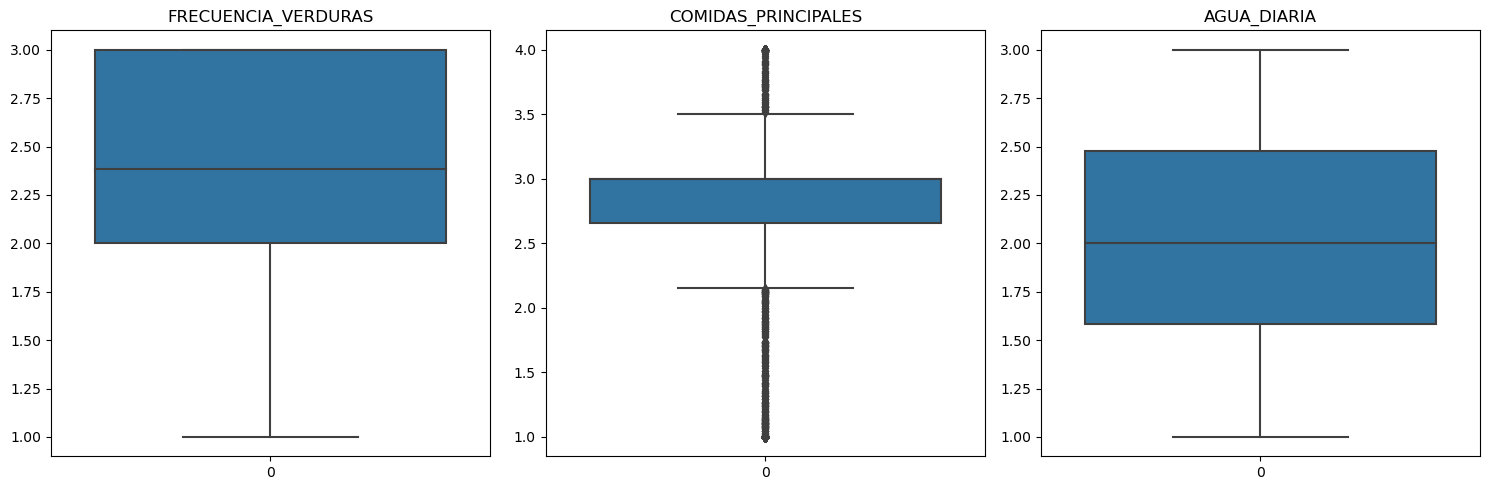

In [47]:
graficar_boxplots_4(df_obesidad, variables2)

**Frecuencia verduras:** En este boxplot llama la atención la variabilidad en la frecuencia con la que las personas comen verduras al día, lo que nos da un boxplot que muestra una variabilidad significativa en los datos.

**Comidas principales:** El gráfico de esta variable contiene una gran cantidad de datos por fuera de la caja, sin embargo, no se consideran atípicos dado que su escala es coherente.

**Consumo de agua diario:** Por otro lado, el boxplot del consumo de agua diario muestra un comportamiento normal.

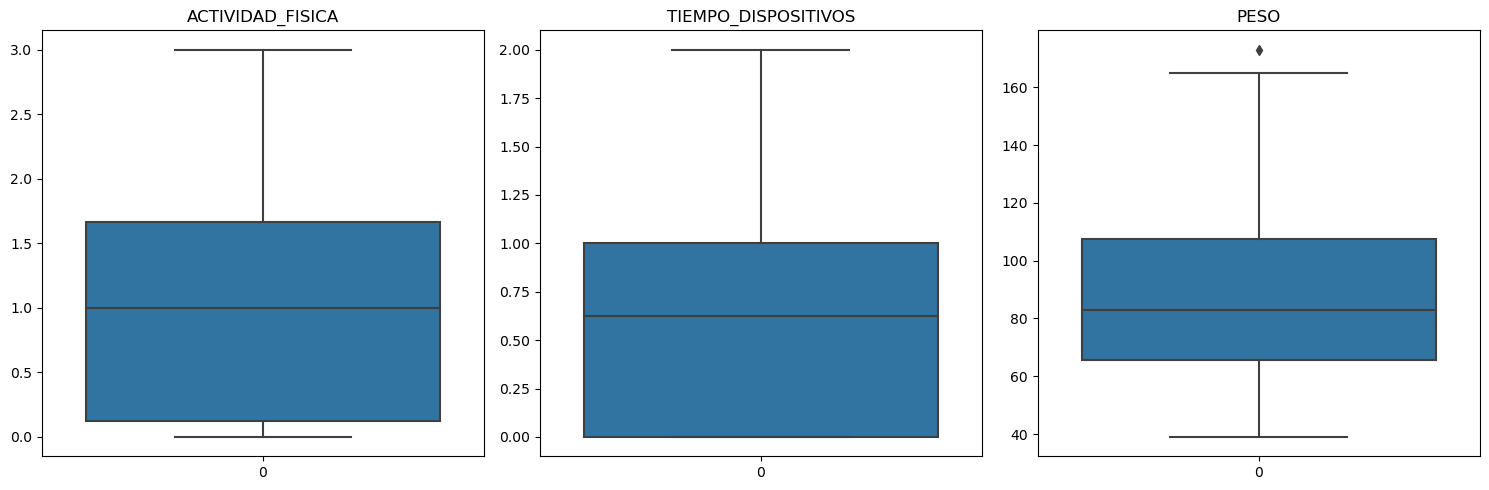

In [51]:
graficar_boxplots_4(df_obesidad, variables3)

En el caso de la actividad física y el tiempo que pasan al frente de dispositivos concentra la mayoría de sus observaciones en la parte baja de la figura, con medias más cercanas a cero, sin embargo, no presenta datos atípicos ni extremos que sean problemáticos.

## **Tratamiento de datos**

Jerarquizar la variable *'MEDIO_TRANSPORTE'* de modo que las categorías que correspondan a que la persona no realice un esfuerzo físico se reemplace por 0, y por el contrario las personas que si realicen un esfuerzo físico para desplazarse se reemplace por 1. De este modo se jerarquizan las clases pertenecientes a la variable.

In [36]:
df_obesidad['MEDIO_TRANSPORTE'] = df_obesidad['MEDIO_TRANSPORTE'].map({'Motorbike': 0, 'Automobile':0, 'Public_Transportation':0,'Bike': 1, 'Walking': 1})

In [37]:
df_obesidad

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,0
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,0
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,0
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,1
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,0
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,0
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,0
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,0


Convertir las columnas binarias en 1 y 0 utilizando la función **'replace'**:

In [38]:
df_obesidad["GENERO"] = df_obesidad["GENERO"].replace(['Female', 'Male'], [1, 0])                   #Female es 1 y Male es 0
df_obesidad["HISTORIAL_FAMILIAR"] = df_obesidad["HISTORIAL_FAMILIAR"].replace(['yes','no'],[1,0])   # yes es 1 y no es 0
df_obesidad["ALIMENTOS_CALORIAS"] = df_obesidad["ALIMENTOS_CALORIAS"].replace(['yes','no'],[1,0])   # yes es 1 y no es 0
df_obesidad["FUMADOR"] = df_obesidad["FUMADOR"].replace(['yes','no'],[1,0])                         # yes es 1 y no es 0
df_obesidad["MONITOREA_CALORIAS"] = df_obesidad["MONITOREA_CALORIAS"].replace(['yes','no'],[1,0])   # yes es 1 y no es 0

Ahora, para tratar las variables tipo object que son categóricas ordinales, se reemplazan por números.

In [40]:
df_obesidad['ENTRE_COMIDAS'] = df_obesidad['ENTRE_COMIDAS'].replace(['no','Sometimes','Frequently','Always'],[0,1,2,3])
df_obesidad['FRECUENCIA_ALCOHOL'] = df_obesidad['FRECUENCIA_ALCOHOL'].replace(['no','Sometimes','Frequently','Always'],[0,1,2,3])

In [41]:
df_obesidad.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,1,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0
1,1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0
2,0,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0


In [42]:
df_oficial = df_obesidad

In [43]:
df_oficial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GENERO               2087 non-null   int64  
 1   EDAD                 2087 non-null   float64
 2   ALTURA               2087 non-null   float64
 3   PESO                 2087 non-null   float64
 4   HISTORIAL_FAMILIAR   2087 non-null   int64  
 5   ALIMENTOS_CALORIAS   2087 non-null   int64  
 6   FRECUENCIA_VERDURAS  2087 non-null   float64
 7   COMIDAS_PRINCIPALES  2087 non-null   float64
 8   ENTRE_COMIDAS        2087 non-null   int64  
 9   FUMADOR              2087 non-null   int64  
 10  AGUA_DIARIA          2087 non-null   float64
 11  MONITOREA_CALORIAS   2087 non-null   int64  
 12  ACTIVIDAD_FISICA     2087 non-null   float64
 13  TIEMPO_DISPOSITIVOS  2087 non-null   float64
 14  FRECUENCIA_ALCOHOL   2087 non-null   int64  
 15  MEDIO_TRANSPORTE     2087 non-null   int64 

### **Gráficos después de tratamiento**

In [44]:
def visualizar_histogramas_20(df, columnas, nfilas=3, ncolumnas=3):
    
  # Crear una figura de nfilas x ncolumnas subplots
  fig, axes = plt.subplots(nfilas, ncolumnas, figsize=(12, 12))

  # Recorrer las columnas y crear un histograma para cada una
  for i, columna in enumerate(columnas):
    row = i // ncolumnas
    col = i % ncolumnas
    axes[row, col].hist(df[columna])

  # Ajustar el título y etiquetas del subplot
    axes[row, col].set_title(columna, fontsize=8)  # Reducir el tamaño del título
    axes[row, col].set_xlabel(columna, fontsize=8)  # Reducir el tamaño de la etiqueta del eje X
    axes[row, col].set_ylabel('Frecuencia', fontsize=8)  # Reducir el tamaño de la etiqueta del eje Y

    # Ajustar el diseño de la figura
    fig.suptitle('Histogramas', fontsize=12)  # Ajustar el tamaño del título principal
    fig.tight_layout()

  # Mostrar la figura
  plt.show()

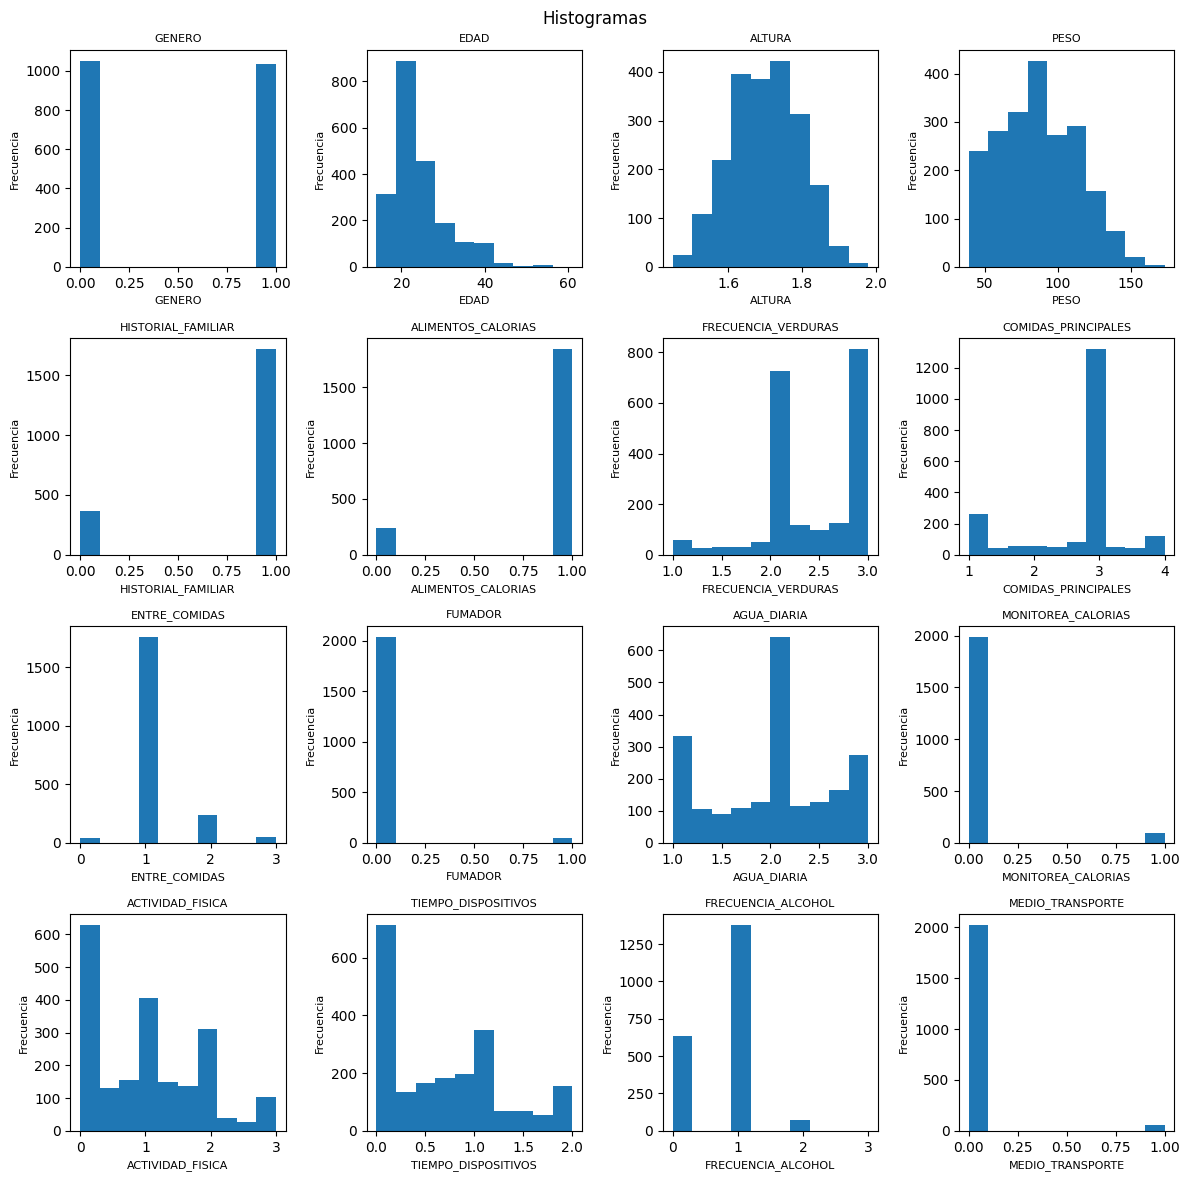

In [45]:
visualizar_histogramas_20(df_oficial, columnas=df_oficial.columns, nfilas=4, ncolumnas=4)

De la gráfica se puede evidenciar que existen variables desbalanceadas que se podrían eliminar dada la poca explicabilidad que ofrecen, por ejemplo: '*FUMADOR*', '*MONITOREA_CALORIAS*', '*MEDIO_TRANSPORTE*'.

### **Eliminación de columnas**

In [46]:
df_oficial = df_oficial.drop(['MEDIO_TRANSPORTE', 'FUMADOR', 'MONITOREA_CALORIAS'], axis=1)

In [47]:
df_oficial.head(5)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL
0,1,21.0,1.62,64.0,1,0,2.0,3.0,1,2.0,0.0,1.0,0
1,1,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,3.0,0.0,1
2,0,23.0,1.80,77.0,1,0,2.0,3.0,1,2.0,2.0,1.0,2
3,0,27.0,1.80,87.0,0,0,3.0,3.0,1,2.0,2.0,0.0,2
4,0,22.0,1.78,89.8,0,0,2.0,1.0,1,2.0,0.0,0.0,1


# **Modelos de clustering - Aprendizaje no supervisado**

# **1. K-means**

En primer lugar se realiza el escalado de los datos para proceder al montaje de los modelos.

In [48]:
scaler = StandardScaler()
df_oficial_std=pd.DataFrame(scaler.fit_transform(df_oficial),columns=df_oficial.columns)
df_oficial_std.head(5)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,-1.186977,0.554211,-1.411836
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,1.082164,0.390906,-0.318128,1.636552,2.328908,-1.090505,0.522834
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,1.156947,0.554211,2.457503
3,-0.991887,0.415705,1.044677,0.005395,-2.172052,-2.754719,1.082164,0.390906,-0.318128,-0.007810,1.156947,-1.090505,2.457503
4,-0.991887,-0.369560,0.830001,0.112328,-2.172052,-2.754719,-0.788364,-2.225418,-0.318128,-0.007810,-1.186977,-1.090505,0.522834


### **1.1. K-means con datos base escalados**

Número óptimo de clusters para los datos base escalados:

In [49]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(df_oficial_std)
    inertia_list.append(kmeans.inertia_)

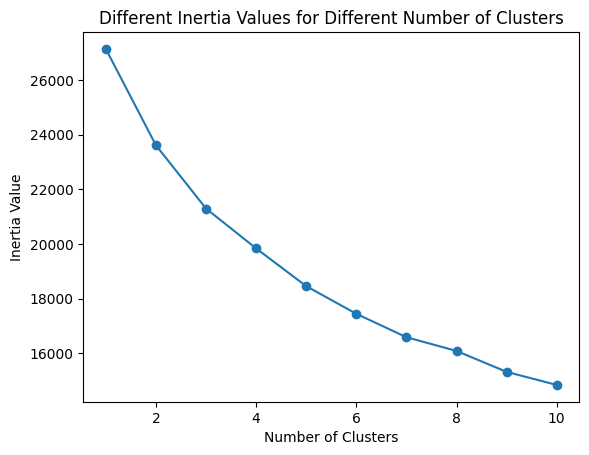

In [50]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [51]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

5

De acuerdo con la prueba del codo y el KneeLocator se utilizarán 5 clusters.

In [52]:
# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 5)
model_kmeans.fit(df_oficial_std)

KMeans(n_clusters=5)

In [53]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df_oficial_std, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df_oficial_std, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  19092.099081767265
Silhouette Score:  0.12115572071769365
Calinski harabasz score:  219.16123051844238


Una vez ejecutado el modelo de K-means para el conjunto de datos sin reducción de la dimensionalidad se obtiene un Silhouette Score de 0.1211, el cual es cercano a 0 por ende se puede entender que el modelo no agrupa de forma tan precisa o que la separación entre clusters no es considerable. Además, el Calinski Harabasz Score arroja un valor de 219.16 el cual se debe comparar con otros modelos de K-means para poder concluir.

In [54]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df_oficial_std)
Cluster_1

array([2, 2, 2, ..., 1, 1, 1])

In [55]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable:
df_final_1 = df_oficial_std.copy()
df_final_1['Cluster_1']= Cluster_1

df_final_1.head()

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,Cluster_1
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,-1.186977,0.554211,-1.411836,2
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,1.082164,0.390906,-0.318128,1.636552,2.328908,-1.090505,0.522834,2
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,1.156947,0.554211,2.457503,2
3,-0.991887,0.415705,1.044677,0.005395,-2.172052,-2.754719,1.082164,0.390906,-0.318128,-0.007810,1.156947,-1.090505,2.457503,2
4,-0.991887,-0.369560,0.830001,0.112328,-2.172052,-2.754719,-0.788364,-2.225418,-0.318128,-0.007810,-1.186977,-1.090505,0.522834,2


In [56]:
df_final_1.Cluster_1.value_counts()

Cluster_1
1    673
0    466
4    458
3    255
2    235
Name: count, dtype: int64

Una vez se predicen los clusters, se observa que el cluster 1 es el que mayor número de observaciones posee. Además, los clusters 2 y 3 son los que menos observaciones agrupa, sin embargo, se mantiene una cantidad de observaciones por cluster que no se distancia notablemente sobre otro.

### **1.2. K-means con reducción de dimensionalidad PCA + optimización de hiperparámetros**

Inicialmente se realiza una reducción de la dimensionalidad de modo que se explique el 55% de la varianza. Se decide elegir este porcentaje dado que al realizar varias pruebas se observa que al aumentar la varianza hasta el 85% se obtiene como resultado alrededor de 10 componentes, los cuales dificultaban el análisis y los últimos componentes no lleganba a explicar un porcentaje significativo de la varianza.

In [57]:
#Cree un dataset reducido con el 55% de la varianza explicada
pca = PCA(n_components=0.55).fit(df_oficial_std)

#Veamos cuántas componentes ha conservado PCA:
pca.n_components_

5

In [58]:
vp = pd.DataFrame(pca.components_)
vp.columns = [i for i in df_oficial_std.columns]
vp

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL
0,0.348539,-0.131426,-0.488524,-0.493430,-0.379754,-0.249829,-0.020829,-0.143905,0.237396,-0.249448,-0.099990,0.024221,-0.148939
1,-0.361526,-0.396607,0.320836,-0.244045,-0.233487,-0.172633,-0.233530,0.217928,0.218393,0.102175,0.456234,0.289151,-0.115185
2,0.344874,-0.171420,-0.003597,0.135164,-0.083684,-0.210525,0.643489,0.327094,0.177281,0.323205,0.217818,-0.093086,0.262683
3,-0.264595,0.485161,0.109485,-0.079373,-0.137190,-0.377257,-0.042300,0.101629,0.175376,-0.091924,0.157280,-0.661843,-0.032862
4,-0.062871,0.000503,0.121690,0.004695,-0.254830,0.261773,-0.138318,0.334114,0.304549,-0.346884,-0.321652,0.029881,0.632106


In [59]:
vp_transpuesto = vp.transpose()

# Mostrar el DataFrame transpuesto para determinar la primera variable latente
vp_transpuesto_ordenado = vp_transpuesto.sort_values(by=3, ascending=False)

vp_transpuesto_ordenado

,0,1,2,3,4
EDAD,-0.131426,-0.396607,-0.171420,0.485161,0.000503
ENTRE_COMIDAS,0.237396,0.218393,0.177281,0.175376,0.304549
ACTIVIDAD_FISICA,-0.099990,0.456234,0.217818,0.157280,-0.321652
ALTURA,-0.488524,0.320836,-0.003597,0.109485,0.121690
COMIDAS_PRINCIPALES,-0.143905,0.217928,0.327094,0.101629,0.334114
FRECUENCIA_ALCOHOL,-0.148939,-0.115185,0.262683,-0.032862,0.632106
FRECUENCIA_VERDURAS,-0.020829,-0.233530,0.643489,-0.042300,-0.138318
PESO,-0.493430,-0.244045,0.135164,-0.079373,0.004695
AGUA_DIARIA,-0.249448,0.102175,0.323205,-0.091924,-0.346884
HISTORIAL_FAMILIAR,-0.379754,-0.233487,-0.083684,-0.137190,-0.254830


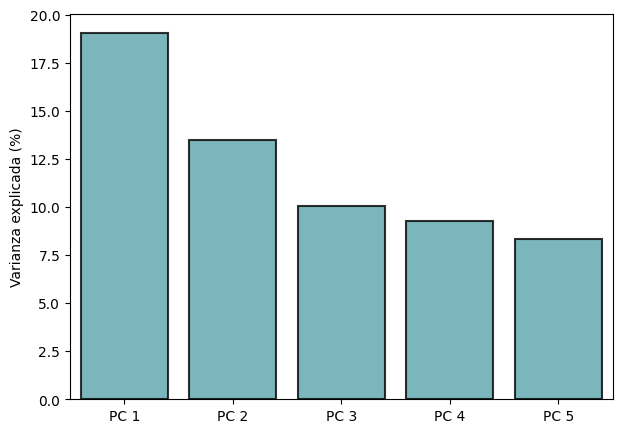

In [60]:
# --- Varianza explicada ---
PCA_variance = pd.DataFrame({'Varianza explicada (%)':
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 6)],
                  y = PCA_variance['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

In [61]:
PCA_variance

,Varianza explicada (%)
0,19.070670
1,13.481000
2,10.070296
3,9.276776
4,8.313578


In [62]:
PCA_variance.sum()

Varianza explicada (%)    60.212319
dtype: float64

Una vez se realiza la reducción de la dimensionalidad a través de PCA se obtiene como resultado un total de **5 componentes**, los cuales tienen la capacidad de explicar alrededor del 60% de la varianza, donde el componente 0 explica el 19% de ella.

In [63]:
X1_pca = pca.fit_transform(df_oficial_std)
X1_pca

array([[ 2.02722901,  0.12112581, -0.25479124, -0.06313426, -1.3627704 ],
       [ 1.57367378,  0.48814722,  2.8700335 ,  1.19126363, -2.28107689],
       [-0.71066372,  1.84203109,  0.58870757,  1.0320908 ,  0.69248263],
       ...,
       [-1.31877774, -0.76887424,  1.55828552, -0.68426132,  0.02145736],
       [-1.58091511, -0.96573889,  1.87071479, -0.66393784, -0.34964382],
       [-1.55195727, -0.92303491,  1.84772786, -0.8800662 , -0.30808952]])

In [64]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X1_pca)
    inertia_list.append(kmeans.inertia_)

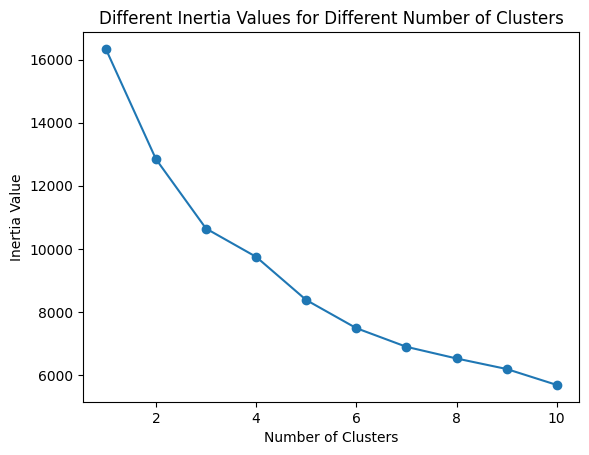

In [65]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [66]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

5

Una vez se realiza la prueba del codo para los datos reducidos se obtiene que el número óptimo de clusters con el modelo K-means con PCA es de 5 clusters.

In [67]:
# --- Modelo K-means ---
model_kmeans_pca_1 = KMeans(n_clusters = 5)
model_kmeans_pca_1.fit(X1_pca)

KMeans(n_clusters=5)

In [68]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca_1.inertia_)
print('Silhouette Score: ', silhouette_score(X1_pca, model_kmeans_pca_1.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X1_pca, model_kmeans_pca_1.labels_))

 ### K-MEANS ###
Inertia:  8257.616542967677
Silhouette Score:  0.23409070137994445
Calinski harabasz score:  509.2153357782311


Una vez se ejecuta el modelo K-means con PCA se obtienen métricas realmente superiores al K-means con los datos iniciales escalados, sin embargo, se ejecuta la optimización de hiperparámetros con el objetivo de aumentar el valor de las métricas de desempeño.

### **Optimización de hiperparámetros**

In [69]:
# Identificación de parametros de optimización

print("+----------------------\nModelo - K-means:")
pprint.pprint(model_kmeans_pca_1.get_params())

+----------------------
Modelo - K-means:
{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 5,
 'n_init': 'auto',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}


In [70]:
# Definición de parametros para optimización

param = {
    'algorithm' : ['lloyd', 'elkan'],
    'init' : ['k-means++', 'random'],
    'max_iter' : [100, 300, 1000],
    'random_state' : [42],
    'n_init' : [10, 30, 50]
}


In [71]:
# Búsqueda aleatoria

# Definición de cuadricula de búsqueda
rand_k = RandomizedSearchCV(model_kmeans_pca_1, param_distributions=param)

# Iniciar la búsqueda
rand_k.fit(X1_pca)

RandomizedSearchCV(estimator=KMeans(n_clusters=5),
                   param_distributions={'algorithm': ['lloyd', 'elkan'],
                                        'init': ['k-means++', 'random'],
                                        'max_iter': [100, 300, 1000],
                                        'n_init': [10, 30, 50],
                                        'random_state': [42]})

In [72]:
print('Mejores Hiperparámetros: ', rand_k.best_params_)
print('Mejor Score: ', rand_k.best_score_)

Mejores Hiperparámetros:  {'random_state': 42, 'n_init': 10, 'max_iter': 300, 'init': 'random', 'algorithm': 'elkan'}
Mejor Score:  -2233.0912373670353


In [73]:
# --- Modelo K-means ---
model_kmeans_pca_1 = KMeans(n_clusters = 5, random_state=42, n_init=10, max_iter=300, init='random', algorithm='elkan')
model_kmeans_pca_1.fit(X1_pca)

KMeans(algorithm='elkan', init='random', n_clusters=5, n_init=10,
       random_state=42)

In [74]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca_1.inertia_)
print('Silhouette Score: ', silhouette_score(X1_pca, model_kmeans_pca_1.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X1_pca, model_kmeans_pca_1.labels_))

 ### K-MEANS ###
Inertia:  8253.584518629134
Silhouette Score:  0.23565073866503813
Calinski harabasz score:  509.71837022178255


Ahora, una vez se ejecuta el modelo K-means optimizado con el conjunto de datos reducido se obtiene que el Silhoutte score es de 0.235, métrica que es superior al resultado obtenido en el K-means realizado al conjunto de datos sin reducción de dimensionalidad. Así mismo, el valor de Calinski Harabasz arroja como resultado 509.71, el cual también es superior a la métrica obtenida en el K-means anterior. Por ende, se concluye que por ahora la clusterización realizada por K-means al realizar reducción de dimensionalidad con PCA es la más adecuada.

In [75]:
# Predicción de los clusters
Cluster_2 = model_kmeans_pca_1.fit_predict(X1_pca)

df_final_1['Cluster_2']= Cluster_2

df_final_1.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,Cluster_1,Cluster_2
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,-1.186977,0.554211,-1.411836,2,0
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,1.082164,0.390906,-0.318128,1.636552,2.328908,-1.090505,0.522834,2,2
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,1.156947,0.554211,2.457503,2,1


In [76]:
df_final_1.Cluster_2.value_counts()

Cluster_2
3    540
0    412
1    381
2    380
4    374
Name: count, dtype: int64

Al igual que el K-means anterior se observa que la cantidad de datos agrupados en cada cluster no se distancia notablemente sobre los demás.

Ahora, se decide realizar el gráfico con los primero 3 componentes (los cuales explican alrededor del 40% de la varianza) para observar cómo se comporta la clusterización. De ella observamos que se está realizando una agrupacióna aceptable, sin embargo, parece existir cierto ruido dentro de cada grupo que no permite obtener una agrupación más clara.

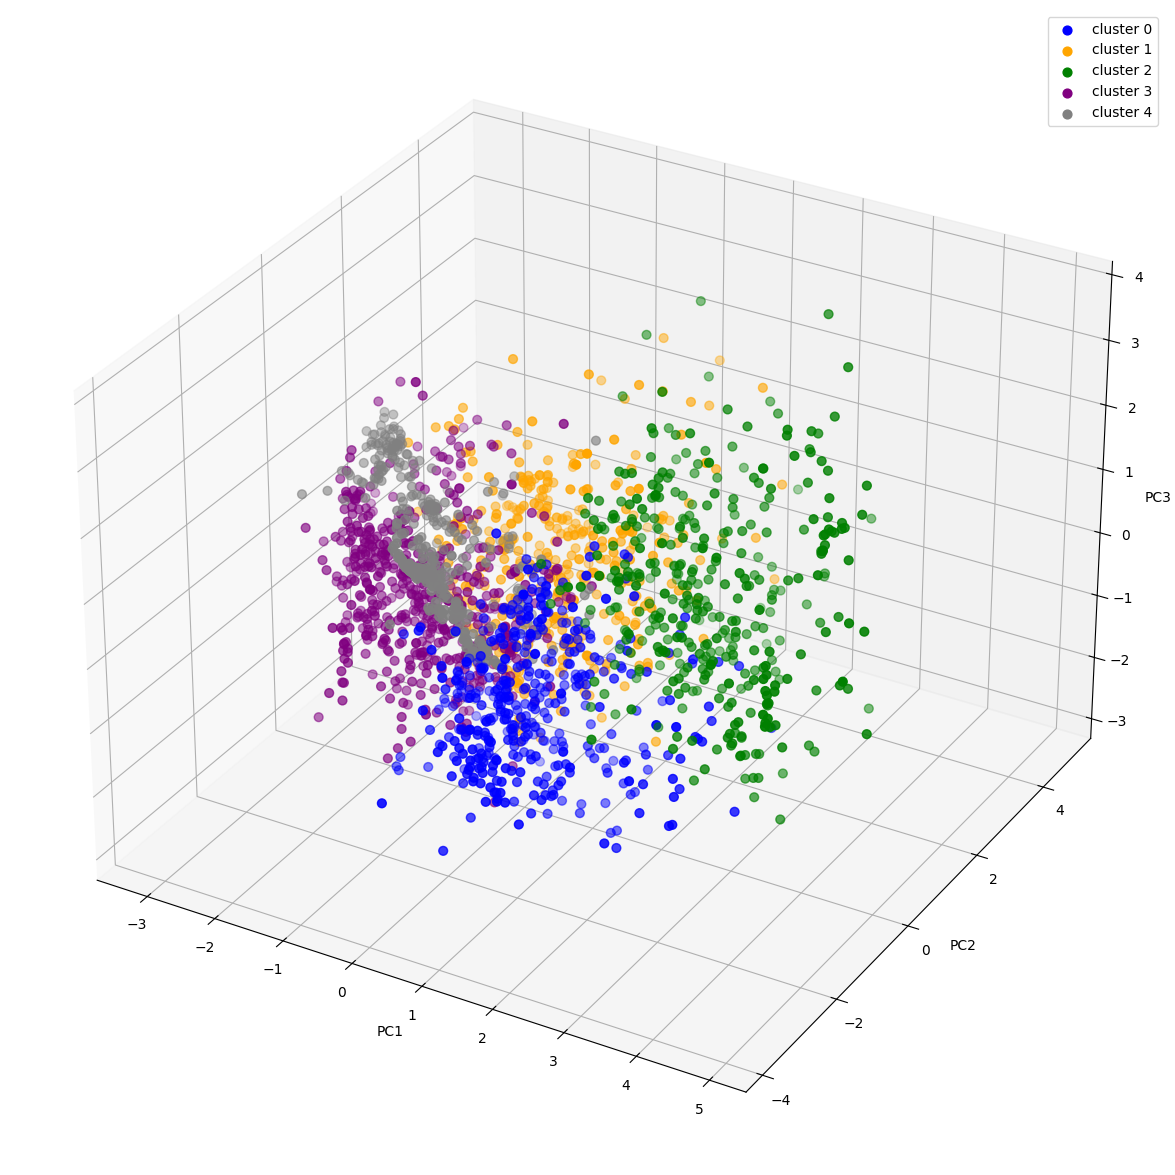

In [79]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_pca[Cluster_2 == 0,0],X1_pca[Cluster_2 == 0,1],X1_pca[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X1_pca[Cluster_2 == 1,0],X1_pca[Cluster_2 == 1,1],X1_pca[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X1_pca[Cluster_2 == 2,0],X1_pca[Cluster_2 == 2,1],X1_pca[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X1_pca[Cluster_2 == 3,0],X1_pca[Cluster_2 == 3,1],X1_pca[Cluster_2 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X1_pca[Cluster_2 == 4,0],X1_pca[Cluster_2 == 4,1],X1_pca[Cluster_2 == 4,2], s = 40 , color = 'gray', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
#ax.view_init(elev=270, azim=90)
plt.show()

## **2. DBScan**

### **2.1. DBScan con datos base escalados**

In [80]:
from sklearn.neighbors import NearestNeighbors

# Selección de hiperparámetros eps

# Gráfica de distancias K
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(df_oficial_std)

distances, *other = neighbors.kneighbors(df_oficial_std)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)

(2087,)


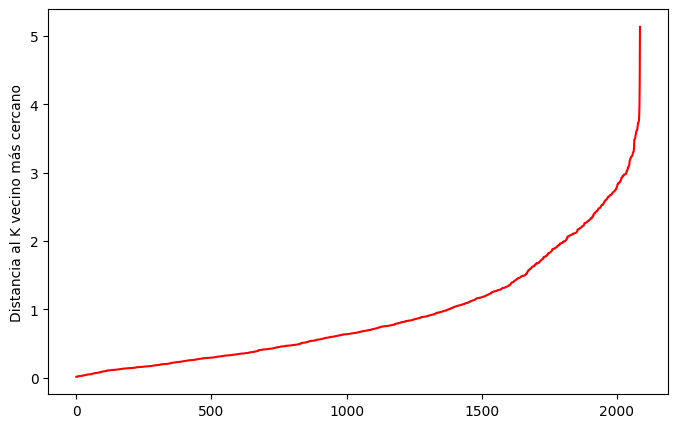

In [81]:
#plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [82]:
# Selección del punto de curvatura máxima
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

2033

In [83]:
# Epsilon óptimo
epsilon = distances[kl.elbow]
epsilon

2.9798400438803028

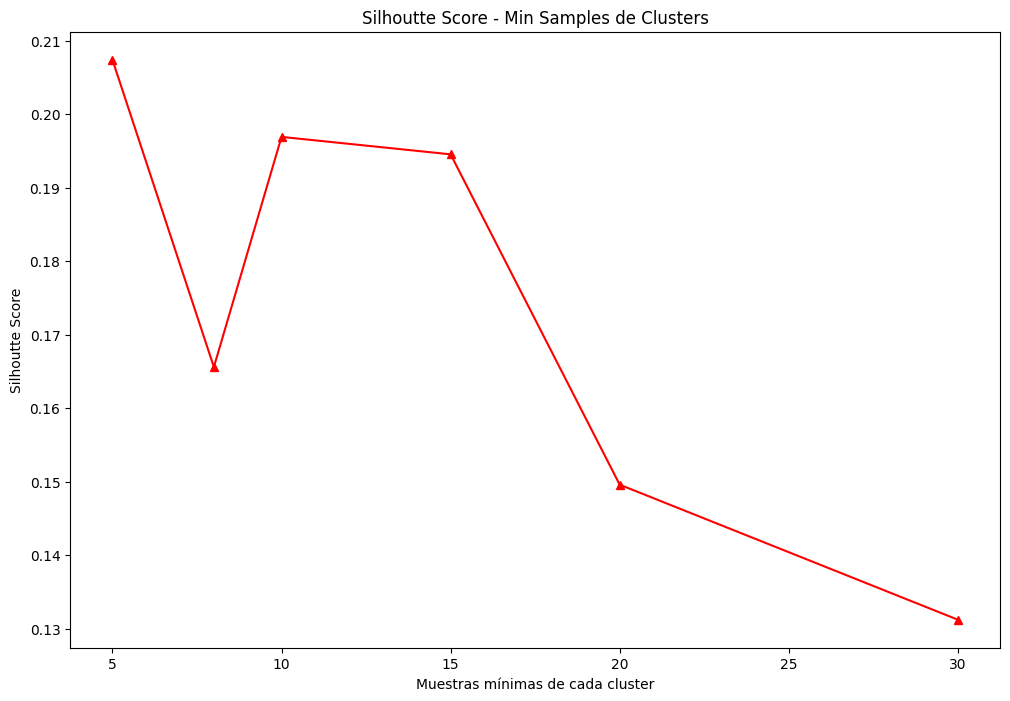

In [84]:
# Selección de hiperparámetros min_sample
silhoutte_coefs = []

for min_points in [5, 8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(df_oficial_std)
    silhoutte_coefs.append(silhouette_score(df_oficial_std, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([5, 8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

De la gráfica se observa que el número mínimo demuestras óptimo para el modelo DBScan es de 5, ya que en ese punto se alcanza el Score de silueta mayor.

In [85]:
# Modelo DBSCAN
model_db = DBSCAN(eps = epsilon, min_samples = 5, n_jobs=-1)
model_db.fit(df_oficial_std)

DBSCAN(eps=2.9798400438803028, n_jobs=-1)

In [86]:
# Evaluación del modelo DBSCAN
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(df_oficial_std, model_db.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df_oficial_std, model_db.labels_))

 ### DBSCAN ###
Silhouette Score:  0.20743348742141937
Calinski harabasz score:  115.66340146808024


De acuerdo a los reusltados de las metricas anteriores podemos ver un Silhouette Score:  0.207, lo que sugiere que los clusters tienen una separación moderada, esto quiere decir que no se agrupan de una forma considerada por su valor tan bajo. Ahora el Calinski harabasz score:  115.66, por lo que se procede a continuar con la reducción de dimensionalidad PCA con el fin de hacer una comparación de resultados.

In [88]:
# Predicción de los clusters
Cluster_3 = model_db.fit_predict(df_oficial_std)
df_final_2 = df_oficial_std.copy()

df_final_2['Cluster_3'] = Cluster_3


df_final_2.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,Cluster_3
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,-1.186977,0.554211,-1.411836,0
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,1.082164,0.390906,-0.318128,1.636552,2.328908,-1.090505,0.522834,0
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,1.156947,0.554211,2.457503,0


In [89]:
df_final_2['Cluster_3'].value_counts()

Cluster_3
 1    1805
 0     201
-1      81
Name: count, dtype: int64

De lo anterior observamos que DBScan sólo nos arroja 2 clusters como tal, donde la gran mayoría de los datos se están agrupando en el cluster 1. Así mismo, DBScan identifica 81 datos atípicos, los cuales son clasificados en el cluster -1. Divho esto se procede a realizar DBScan con PCA para buscar mejorar el desempeño del modelo. 

### **2.2. DBScan con reducción de dimensionalidad PCA + optimización de hiperparámetros**

In [90]:
# Selección de hiperparámetros eps

# Gráfica de distancias K
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(X1_pca)

distances, *other = neighbors.kneighbors(X1_pca)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(2087,)


array([0.00902306, 0.00902306, 0.00955034, ..., 1.90847545, 2.11632325,
       2.94165229])

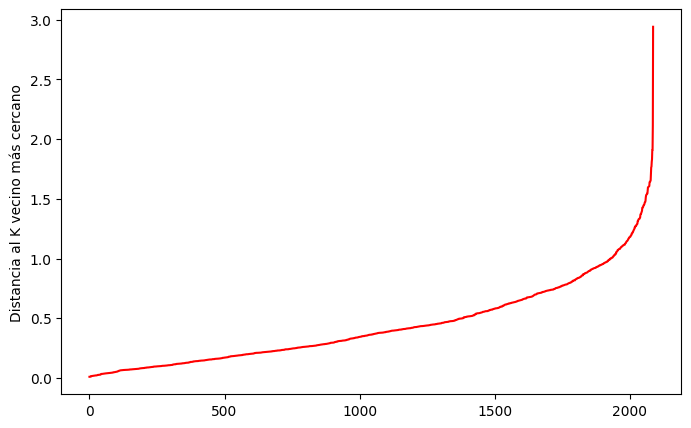

In [91]:
#plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [92]:
# Selección del punto de curvatura máxima
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

2001

In [93]:
# Epsilon óptimo
epsilon = distances[kl.elbow]
epsilon

1.1801989425516768

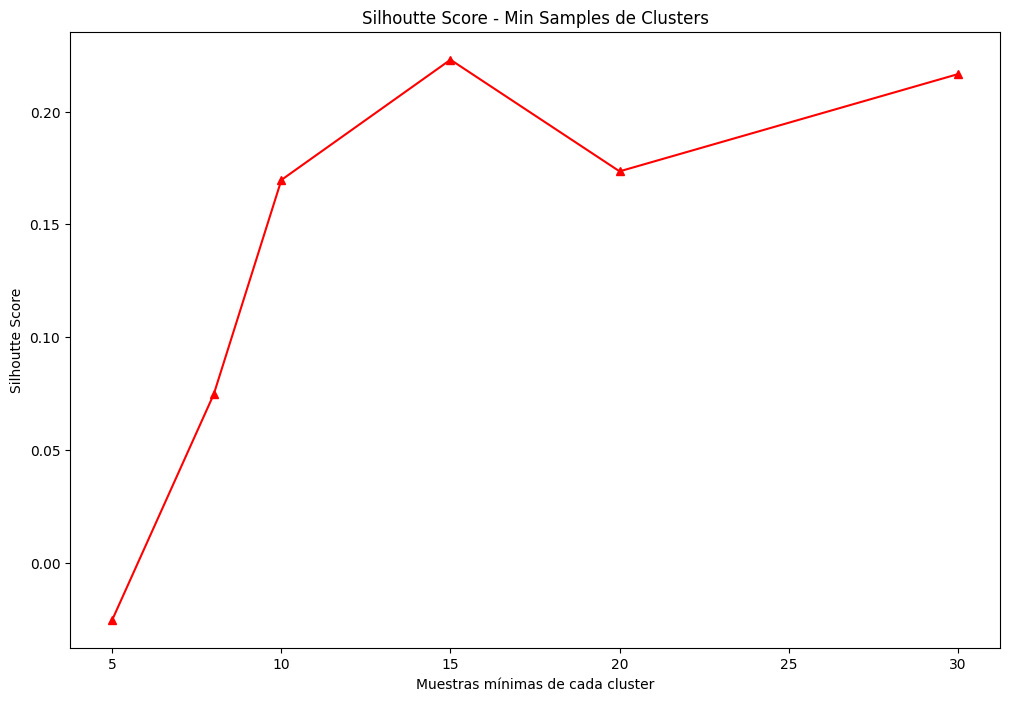

In [94]:
#  Selección de hiperparámetros min_sample
silhoutte_coefs = []

for min_points in [5, 8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(X1_pca)
    silhoutte_coefs.append(silhouette_score(X1_pca, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([5, 8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

Se observa que el número mínimo de muestras es de 15.

In [95]:
# Modelo DBSCAN
model_db_pca = DBSCAN(eps = epsilon, min_samples = 15)
model_db_pca.fit(X1_pca)

DBSCAN(eps=1.1801989425516768, min_samples=15)

In [96]:
# Evaluación del modelo DBSCAN
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X1_pca, model_db_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X1_pca, model_db_pca.labels_))

 ### DBSCAN ###
Silhouette Score:  0.2229511159374001
Calinski harabasz score:  209.49561146631603


Se observa que el modelo DBScan con PCA mejora las métricas arrojadas por el DBScan base, mejorando principalmente el score de Calinski Harabaz, sin embargo, se decide realizar la optimización de hiperparámetros para buscar mejorar dichas métricas.

### **Optimización de hiperparámetros**

In [97]:
# Identificación de parametros de optimización

print("+----------------------\nModelo - DBScan:")
pprint.pprint(model_db_pca.get_params())

+----------------------
Modelo - DBScan:
{'algorithm': 'auto',
 'eps': 1.1801989425516768,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 15,
 'n_jobs': None,
 'p': None}


In [98]:
# Definición de parametros para optimización

param = {
    'metric' : ['euclidean', 'cosine', 'manhattan', 'chebyshev'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10, 30, 50, 100, 500],
    'eps' : [epsilon],
    'min_samples' : [15], 
    'n_jobs' : [-1],
}

In [99]:
# Custom scoring function using silhouette coefficient
def dbscan_silhouette_score(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Using custom scoring function
rand_db = RandomizedSearchCV(model_db_pca, param_distributions=param, scoring=dbscan_silhouette_score)
rand_db.fit(X1_pca)

C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\srest\AppData\Local\Temp\ipykernel_29624\1564475721.py", line 4, in dbscan_silhouette_score
    return silhouette_score(X, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\uti

RandomizedSearchCV(estimator=DBSCAN(eps=1.1801989425516768, min_samples=15),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'eps': [1.1801989425516768],
                                        'leaf_size': [10, 30, 50, 100, 500],
                                        'metric': ['euclidean', 'cosine',
                                                   'manhattan', 'chebyshev'],
                                        'min_samples': [15], 'n_jobs': [-1]},
                   scoring=<function dbscan_silhouette_score at 0x00000198B179BD80>)

In [100]:
print('Mejores Hiperparámetros: ', rand_db.best_params_)
print('Mejor Score: ', rand_db.best_score_)

Mejores Hiperparámetros:  {'n_jobs': -1, 'min_samples': 15, 'metric': 'euclidean', 'leaf_size': 500, 'eps': 1.1801989425516768, 'algorithm': 'auto'}
Mejor Score:  nan


In [102]:
# Modelo DBSCAN
model_db_pca = DBSCAN(eps = epsilon, min_samples = 15, n_jobs=-1, metric='euclidean', leaf_size=500, algorithm='auto')
model_db_pca.fit(X1_pca)

DBSCAN(eps=1.1801989425516768, leaf_size=500, min_samples=15, n_jobs=-1)

In [103]:
# Evaluación del modelo DBSCAN
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X1_pca, model_db_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X1_pca, model_db_pca.labels_))

 ### DBSCAN ###
Silhouette Score:  0.2229511159374001
Calinski harabasz score:  209.49561146631603


Luego de aplicar la reducción de dimensionalidad PCA el Silhouette Score:  0.222 se podria decir que los clusters tienen una mejor separación pero realmente el resultado no es muy significativo. Así mismo, el Calinski harabasz score:  209.49 si tiene un mayor resultado en comparación con el DBScan base, por lo que los clusters estan mejor agrupados con PCA.

Sin embargo, se concluye que el modelo que mejor desempeño obtuvo fue el K-means con PCA dado que obtiene un score de silueta mayor a los demás y presenta un comportamiento más coherente.

In [104]:
# Predicción de los clusters
Cluster_4 = model_db_pca.fit_predict(X1_pca)

df_final_2['Cluster_4']= Cluster_4

df_final_2.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,Cluster_3,Cluster_4
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,-1.186977,0.554211,-1.411836,0,0
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,1.082164,0.390906,-0.318128,1.636552,2.328908,-1.090505,0.522834,0,-1
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,1.156947,0.554211,2.457503,0,0


In [105]:
df_final_2['Cluster_4'].value_counts()

Cluster_4
 0    1709
-1     378
Name: count, dtype: int64

De esto se observa que el modelo DBScan no obtuvo tan buen rendimiento dado que sólo genera 1 clúster y que detecta gran cantidad de datos atípicos clasificados en el clúster -1.

# **Interpretación de clústers (mejor modelo) - K-means con PCA**

In [106]:
df_oficial.columns

Index(['GENERO', 'EDAD', 'ALTURA', 'PESO', 'HISTORIAL_FAMILIAR',
       'ALIMENTOS_CALORIAS', 'FRECUENCIA_VERDURAS', 'COMIDAS_PRINCIPALES',
       'ENTRE_COMIDAS', 'AGUA_DIARIA', 'ACTIVIDAD_FISICA',
       'TIEMPO_DISPOSITIVOS', 'FRECUENCIA_ALCOHOL'],
      dtype='object')

In [107]:
df_final = df_final_1[df_oficial.columns]
df_final

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,-1.186977,0.554211,-1.411836
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,1.082164,0.390906,-0.318128,1.636552,2.328908,-1.090505,0.522834
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.788364,0.390906,-0.318128,-0.007810,1.156947,0.554211,2.457503
3,-0.991887,0.415705,1.044677,0.005395,-2.172052,-2.754719,1.082164,0.390906,-0.318128,-0.007810,1.156947,-1.090505,2.457503
4,-0.991887,-0.369560,0.830001,0.112328,-2.172052,-2.754719,-0.788364,-2.225418,-0.318128,-0.007810,-1.186977,-1.090505,0.522834
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,1.008179,-0.530250,0.086470,1.701376,0.460394,0.363013,1.082164,0.390906,-0.318128,-0.454848,0.777546,0.400014,0.522834
2083,1.008179,-0.372239,0.492788,1.790528,0.460394,0.363013,1.082164,0.390906,-0.318128,0.000626,0.385081,-0.104876,0.522834
2084,1.008179,-0.287258,0.531665,1.788482,0.460394,0.363013,1.082164,0.390906,-0.318128,0.081303,0.470422,-0.027545,0.522834
2085,1.008179,0.001389,0.394745,1.775393,0.460394,0.363013,1.082164,0.390906,-0.318128,1.393744,0.148013,-0.126644,0.522834


In [108]:
# Conversión de variables numéricas a valores originales

scaled_train_df1 = pd.DataFrame(scaler.inverse_transform(df_final), columns = df_final.columns)

# Union de data numéricas y categórica
cols = df_final.columns
df_final[cols] = scaled_train_df1
df_final.head(3)

C:\Users\srest\AppData\Local\Temp\ipykernel_29624\1065410935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[cols] = scaled_train_df1


,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL
0,1.0,21.0,1.62,64.0,1.0,1.110223e-16,2.0,3.0,1.0,2.0,0.0,1.0,0.0
1,1.0,21.0,1.52,56.0,1.0,1.110223e-16,3.0,3.0,1.0,3.0,3.0,0.0,1.0
2,0.0,23.0,1.80,77.0,1.0,1.110223e-16,2.0,3.0,1.0,2.0,2.0,1.0,2.0


In [109]:
df_final['PCA1'] = X1_pca[:,0]
df_final['PCA2'] = X1_pca[:,1]
df_final['PCA3'] = X1_pca[:,2]
df_final['Cluster_2'] = df_final_1['Cluster_2']
df_final.head(3)

C:\Users\srest\AppData\Local\Temp\ipykernel_29624\1420339254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['PCA1'] = X1_pca[:,0]


,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,PCA1,PCA2,PCA3,Cluster_2
0,1.0,21.0,1.62,64.0,1.0,1.110223e-16,2.0,3.0,1.0,2.0,0.0,1.0,0.0,2.027229,0.121126,-0.254791,0
1,1.0,21.0,1.52,56.0,1.0,1.110223e-16,3.0,3.0,1.0,3.0,3.0,0.0,1.0,1.573674,0.488147,2.870033,2
2,0.0,23.0,1.80,77.0,1.0,1.110223e-16,2.0,3.0,1.0,2.0,2.0,1.0,2.0,-0.710664,1.842031,0.588708,1


In [110]:
df_final.shape

(2087, 17)

### **Análisis de los 5 componentes obtenidos con K-means + PCA**

In [117]:
# Mostrar el DataFrame transpuesto para determinar la primera variable latente
vp_transpuesto_ordenado = vp_transpuesto.sort_values(by=4, ascending=False)

vp_transpuesto_ordenado

,0,1,2,3,4
FRECUENCIA_ALCOHOL,-0.148939,-0.115185,0.262683,-0.032862,0.632106
COMIDAS_PRINCIPALES,-0.143905,0.217928,0.327094,0.101629,0.334114
ENTRE_COMIDAS,0.237396,0.218393,0.177281,0.175376,0.304549
ALIMENTOS_CALORIAS,-0.249829,-0.172633,-0.210525,-0.377257,0.261773
ALTURA,-0.488524,0.320836,-0.003597,0.109485,0.121690
TIEMPO_DISPOSITIVOS,0.024221,0.289151,-0.093086,-0.661843,0.029881
PESO,-0.493430,-0.244045,0.135164,-0.079373,0.004695
EDAD,-0.131426,-0.396607,-0.171420,0.485161,0.000503
GENERO,0.348539,-0.361526,0.344874,-0.264595,-0.062871
FRECUENCIA_VERDURAS,-0.020829,-0.233530,0.643489,-0.042300,-0.138318


**Componente 0:** Dentro de este componente se observa que las variables que mayor peso tienen son el género (relación directa), el peso y la altura (relación inversa), por lo que se podría entender este componente como el que tiene en cuenta las características físicas particulares de cada persona. 

**Componente 1:** Este componente tiene a la actividad física (relación directa) y a la edad (relación inversa) como las variables que mayor peso obtienen dentro del mismo, por lo que se puede asociar este componente al desarrollo de la persona a través de la práctica de actividad física.

**Componente 2:** Dentro de este componente se observa que la frecuencia con la que comen verduras y el número de comidas principales de las personas al día (relación directa) obtienen un peso realmente considerable para la explicabilidad de este. Por ende, este componente se puede clasificar como el que agrupa los hábitos alimenticios de las personas.

**Componente 3:** En el caso de este componente predomina el peso del tiempo que la persona pasa al frente de dispositivos tecnológicos (relación inversa) y la edad (relación directa), por lo que este componente se puede entender como el que contiene los hábitos de ocio o el sedentarismo de la persona.

**Componente 4:** Finlamente, este componente contiene como variable con mayor peso la frecuencia con la cual la persona consume alcohol (relación directa) y el número de vasos de agua que consumen al día (relación inversa), por lo cual este componente se puede asociar a los hábitos de consumo de bebidas.

### **Análisis gráfico de los clústers**

<Axes: xlabel='Cluster_2', ylabel='count'>

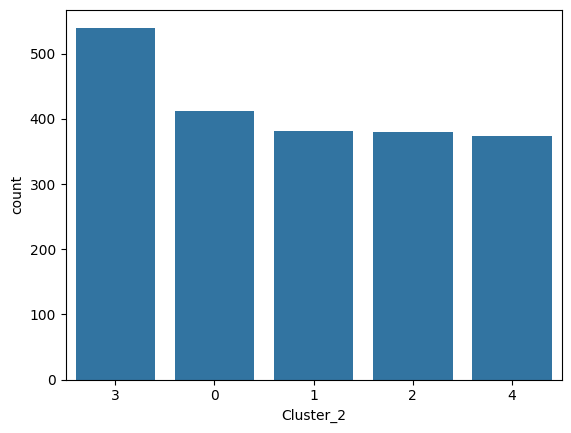

In [182]:
# Composición de los clusters formados
sns.countplot(x="Cluster_2",data=df_final, order = df_final['Cluster_2'].value_counts().index)

Inicialmente, se observa que el clúster 3 es el que posee un mayor número de observaciones, en segundo lugar el clúster 0, y en el caso del clúster 1,2 y 4 posee una cantidad similar de observaciones dentro de sus agrupaciones.

In [177]:
# Composición de los clusters - Media de las variables por cluster
df_final.groupby(['Cluster_2']).mean()

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,PCA1,PCA2,PCA3
Cluster_2,,,,,,,,,,,,,,,,
0,0.750000,28.269126,1.629991,78.648656,0.934466,0.876214,2.312784,2.049615,0.970874,1.789442,0.692562,0.458769,0.410194,0.774633,-1.119620,-0.793578
1,0.107612,20.674241,1.748928,76.544645,0.847769,0.853018,2.188087,2.888184,1.125984,2.274675,1.667837,1.079238,0.425197,-0.361474,1.574927,-0.325279
2,0.823684,20.799229,1.629718,55.811607,0.300000,0.673684,2.450362,2.783916,1.618421,1.686239,1.052260,0.726196,0.702632,2.321590,0.697355,0.487520
3,0.003704,27.094316,1.788285,102.985558,0.975926,0.977778,2.276296,2.830007,1.062963,2.066299,0.988398,0.487996,0.987037,-1.541754,0.103587,-0.396125
4,0.989305,23.439826,1.686140,114.670590,0.997326,1.000000,2.959182,2.958368,1.000000,2.201706,0.693484,0.652620,1.048128,-0.617872,-1.229132,1.282179


In [180]:
df_final.Cluster_2.value_counts()

Cluster_2
3    540
0    412
1    381
2    380
4    374
Name: count, dtype: int64

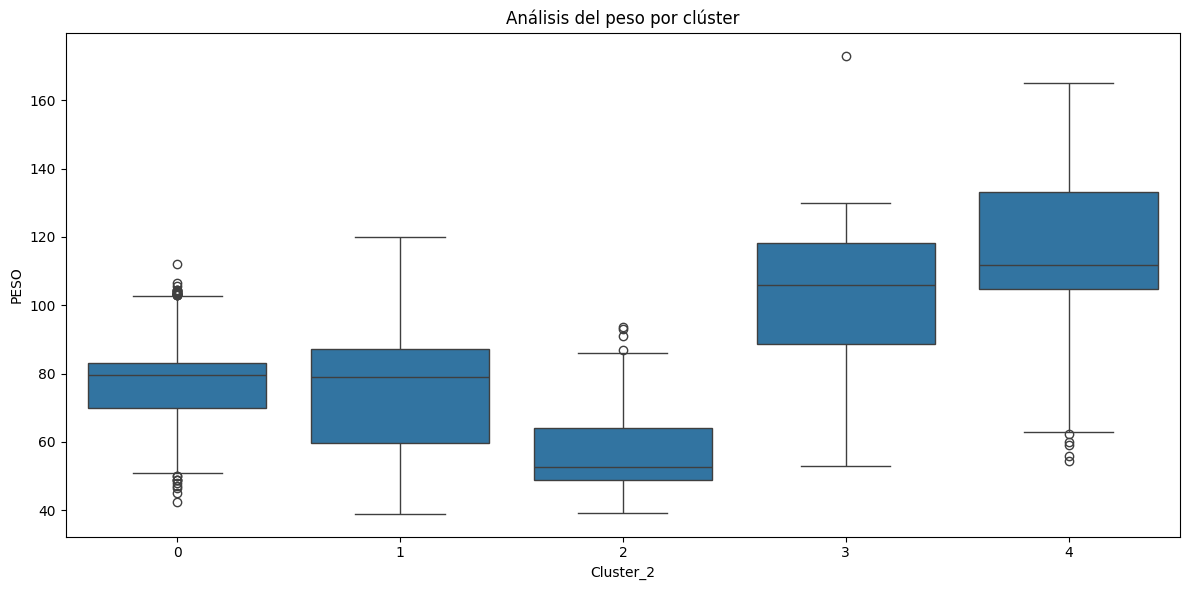

In [160]:
# Análisis del peso

# Assuming your DataFrame is named 'df_final'
temp_peso = df_final[['Cluster_2', 'PESO']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="PESO", 
     data = temp_peso,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis del peso por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("PESO")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

De los boxplots del peso se observa que los los clústers 3 y 4 contienen dentro de sus agrupaciones a las personas con un mayor peso (media: 103 kg y 114 kg respectivamente). Así mismo, se observa que el clúster 2 es el que contiene a las personas con un menor peso (media: 56 kg). Finalmente, el clúster 0 y 1 poseen personas con un peso parecido (media: 76 kg y 78 kg respectivamente).

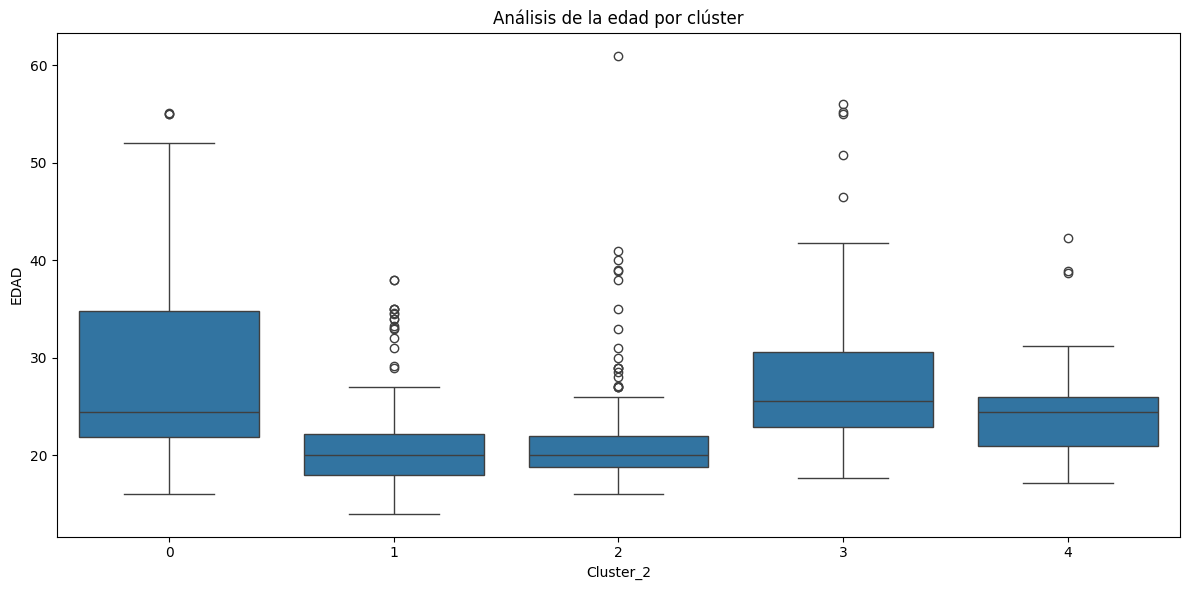

In [161]:
# Análisis de la edad

# Assuming your DataFrame is named 'df_final'
temp_edad = df_final[['Cluster_2', 'EDAD']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="EDAD", 
     data = temp_edad,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis de la edad por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("EDAD")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

En cuanto a la edad se observa que los clústers 0 y 3 son los que poseen las personas con mayor edad (media: 28 años y 27 años respectivamente y una caja mucho más grande). Así mismo, el clúster 2 posee una gran variabilidad en cuanto a este dato dado que posee una persona con una edad cercana a los 60 años pero posee una media de 21 años. Finlamente, los clústers 1 y 2 contienen a las personas más jovenes del estudio.

C:\Users\srest\AppData\Local\Temp\ipykernel_29624\1760996772.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



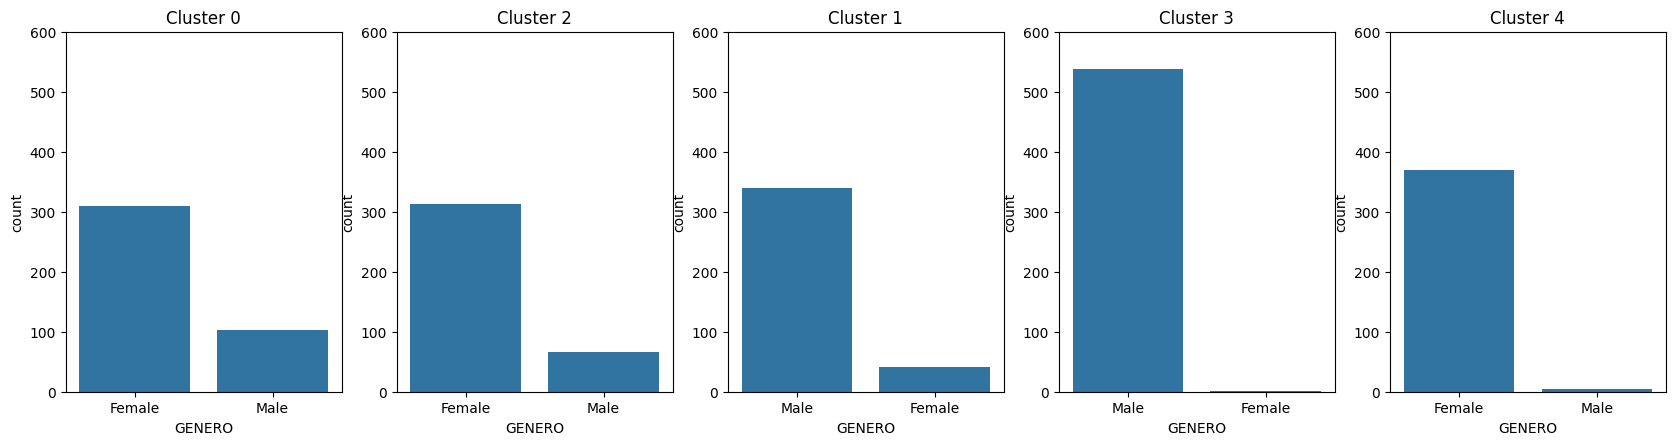

In [179]:
# Análisis del género

temp_genero = df_final[['Cluster_2', 'GENERO']]
temp_genero['GENERO'] = temp_genero['GENERO'].map({1: 'Female', 0: 'Male'})

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

# Find the overall maximum count across all clusters
max_count = temp_genero['GENERO'].value_counts().max()

for i, cluster in enumerate(temp_genero['Cluster_2'].unique()):
    cluster_data = temp_genero[temp_genero['Cluster_2'] == cluster]
    sns.countplot(
        x="GENERO",
        data=cluster_data,
        ax=axs[i]
    )
    axs[i].set_title(f"Cluster {cluster}")  # Set informative titles

# Set the same y-axis limits for all subplots
for ax in axs:
    ax.set_ylim(0, 600)  # Adjust the top limit slightly for spacing

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
plt.show()


En cuanto al género, se observa que el clúster 3 está caracterizado por agrupar prácticamente en su totalidad a hombres (el clúster 3 posee 540 observaciones), por el contrario, el clúster 4 contiene prácticamente en su totalidad a mujeres (el clúster 4 contiene 374 observaciones). Finalmente, los clústers 0 y 2 poseen un comportamiento similar en el cual contienen alrededor de 300 mujeres y alrededor de 85 hombres, y en el caso del clúster 1 contiene alrededor de 340 hombres y 50 mujeres.

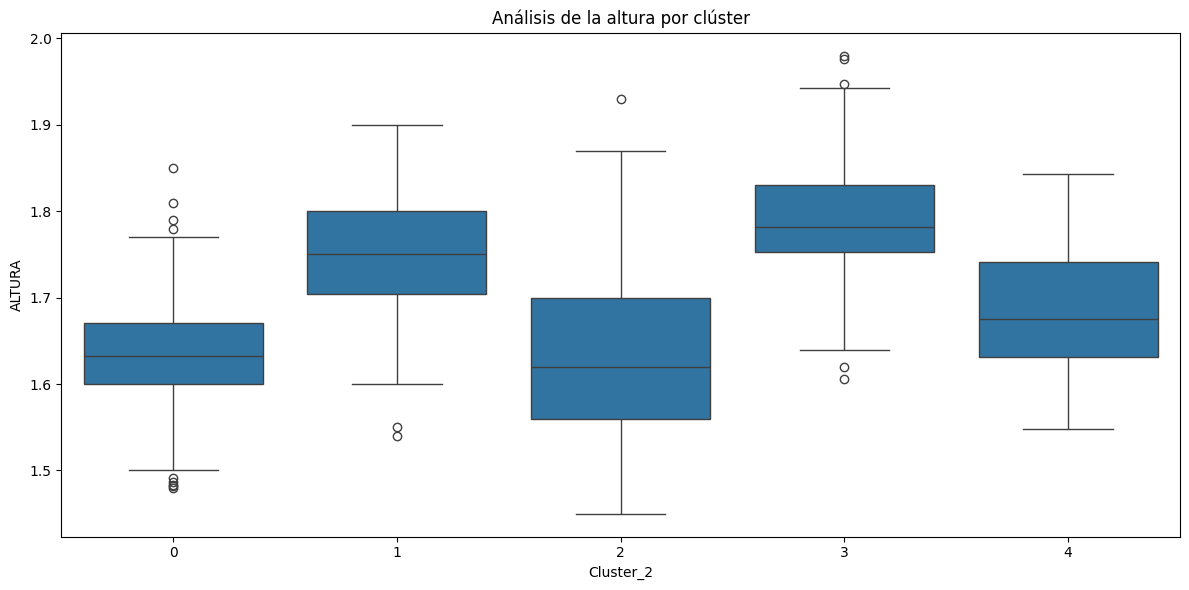

In [181]:
# Análisis de la altura

# Assuming your DataFrame is named 'df_final'
temp_alt = df_final[['Cluster_2', 'ALTURA']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="ALTURA", 
     data = temp_alt,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis de la altura por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("ALTURA")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

En lo que respecta a la altura se observa que los clústers 0 y 2 contienen a las personas con una menor estatura (media cercana a 1.62 metros). Por otro lado, el clúster 3 es el que contiene a las personas con una mayor altura (media: 1.78 metros) con un comprtamiento parecido al clúster 1. Finlamente, el clúster 4 presenta un comportamiento normal con una media cercana a 1.7 metros (media general del dataset inicial).

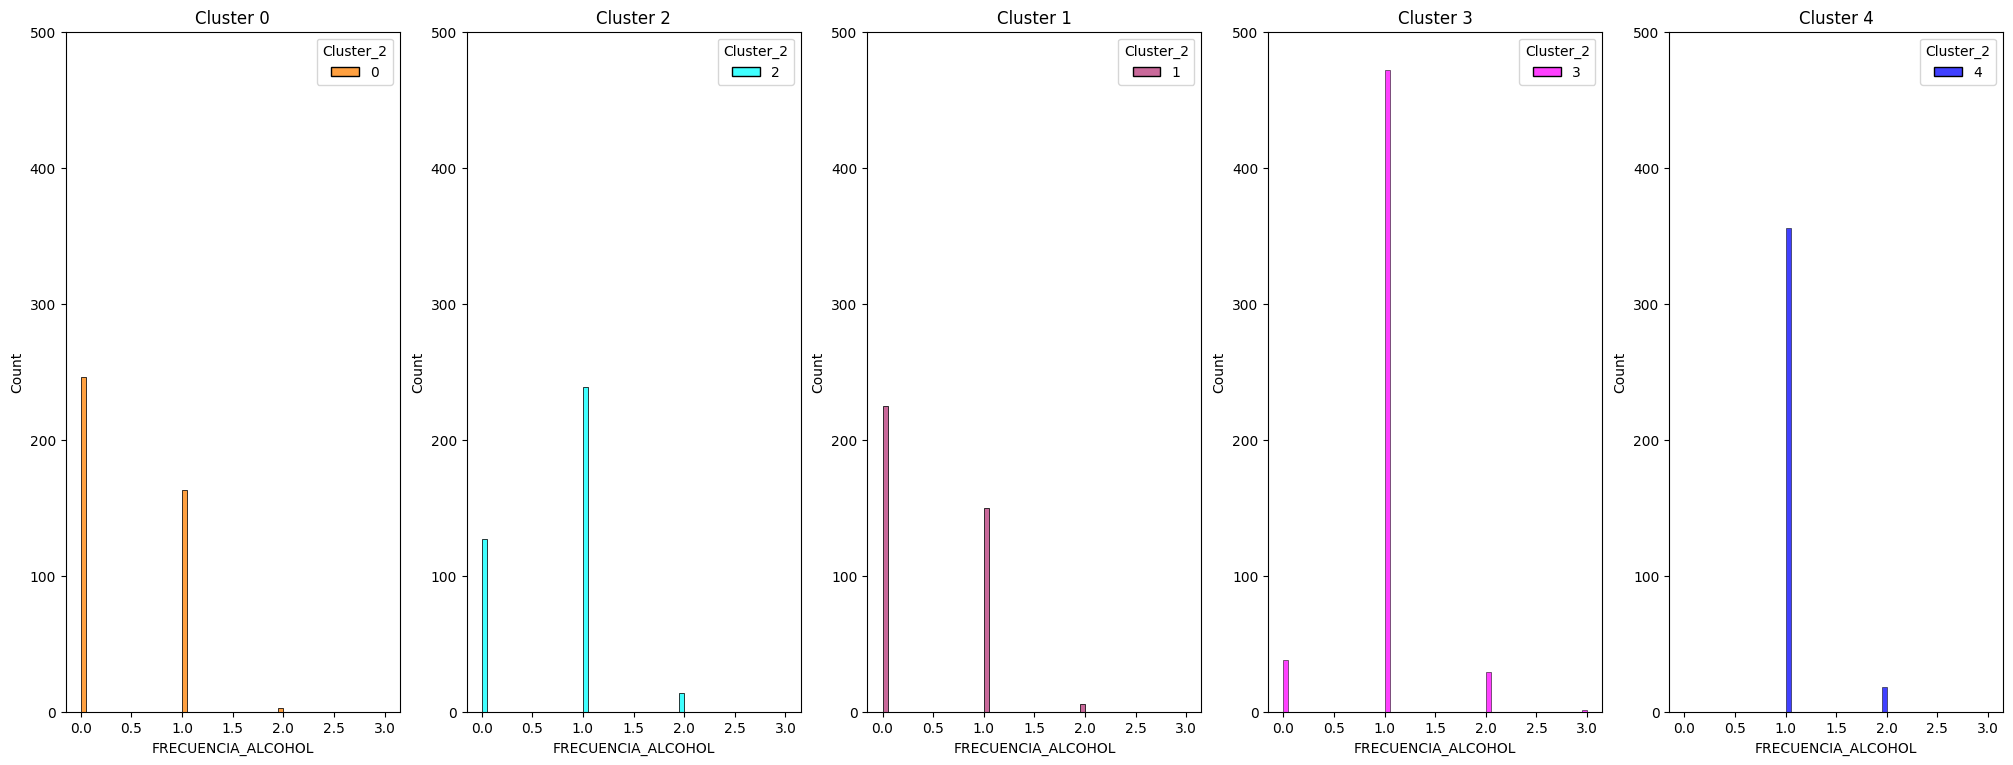

In [208]:
pal = ['autumn', 'cool', 'magma', 'spring', 'winter']  # Color palette for clusters

df_final['FRECUENCIA_ALCOHOL'] = df_final['FRECUENCIA_ALCOHOL'].astype('int32')

# Assuming your DataFrame is named 'df_final'
df_filtered = df_final.copy()  # Avoid modifying original DataFrame

# Calculate overall maximum y-axis value for consistent scaling
max_count = df_filtered.groupby('FRECUENCIA_ALCOHOL')['Cluster_2'].count().max()

fig, axs = plt.subplots(ncols=5, figsize=(25, 10), sharex=True)

for i, cluster in enumerate(df_filtered['Cluster_2'].unique()):
    cluster_data = df_filtered[df_filtered['Cluster_2'] == cluster]
    sns.histplot(
        data=cluster_data,
        x="FRECUENCIA_ALCOHOL",
        hue="Cluster_2",
        palette=pal[i],
        binwidth=.05,
        ax=axs[i],
        multiple='dodge',
        stat='count'  # Ensure count is used for y-axis
    )
    axs[i].set_title(f"Cluster {cluster}")

# Set the same y-axis limits for all subplots
for ax in axs:
    ax.set_ylim(0, 500)  # Adjust top limit slightly for spacing

plt.subplots_adjust(bottom=0.2)  # Adjust spacing to avoid overlapping with x-axis labels
plt.ylabel("Count")
plt.show()

En cuanto al análisis del consumo de alcohol se encuentra que el clúster 3 agrupa más de 450 personas que consumen alcohol a veces, además, presenta alrededor de 40 personas que no consumen alcohol y otras 40 que lo consumen frecunetmente, por ende, este clúster se considera el más pesado si se desea analizar el consumo de alcohol. Así mismo, el clúster 4 presenta alrededor de 350 personas que consumen alcohol a veces. Finalemente los clústers 0 y 1 presentan un comportamiento similar en el que predominan las personas que no consumen alcohol (un poco más de 200) y alrededor de 150 personas que lo consumen a veces.

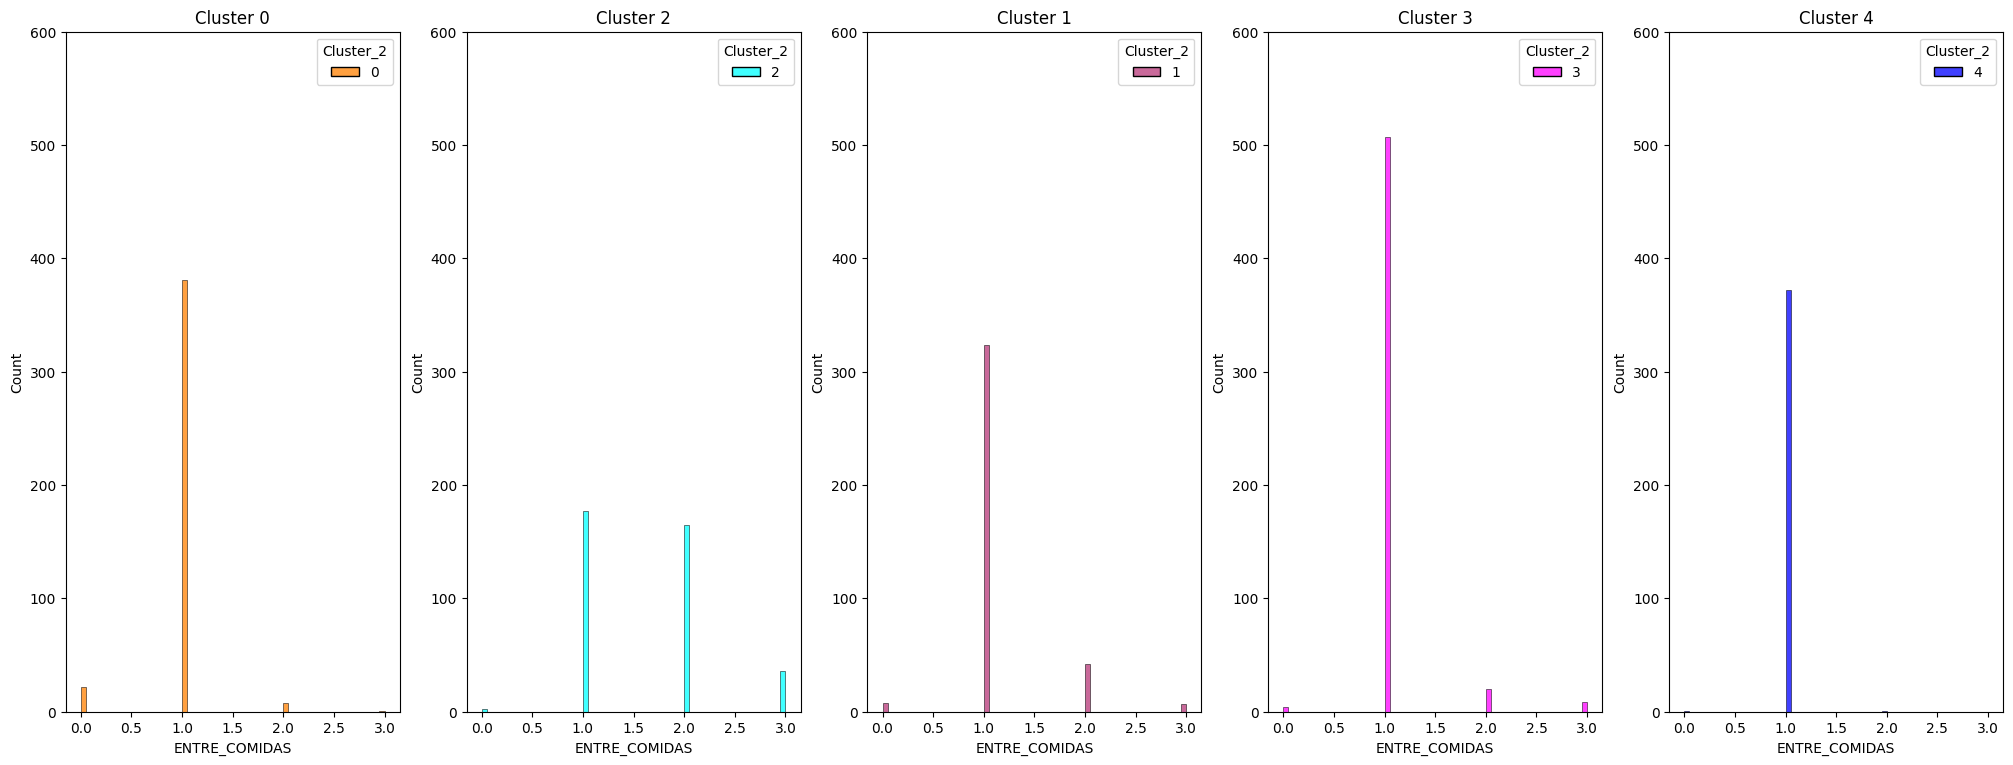

In [210]:
pal = ['autumn', 'cool', 'magma', 'spring', 'winter']  # Color palette for clusters

# Assuming your DataFrame is named 'df_final'
df_filtered = df_final.copy()  # Avoid modifying original DataFrame

# Calculate overall maximum y-axis value for consistent scaling
max_count = df_filtered.groupby('ENTRE_COMIDAS')['Cluster_2'].count().max()

fig, axs = plt.subplots(ncols=5, figsize=(25, 10), sharex=True)

for i, cluster in enumerate(df_filtered['Cluster_2'].unique()):
    cluster_data = df_filtered[df_filtered['Cluster_2'] == cluster]
    sns.histplot(
        data=cluster_data,
        x="ENTRE_COMIDAS",
        hue="Cluster_2",
        palette=pal[i],
        binwidth=.05,
        ax=axs[i],
        multiple='dodge',
        stat='count'  # Ensure count is used for y-axis
    )
    axs[i].set_title(f"Cluster {cluster}")

# Set the same y-axis limits for all subplots
for ax in axs:
    ax.set_ylim(0, 600)  # Adjust top limit slightly for spacing

plt.subplots_adjust(bottom=0.2)  # Adjust spacing to avoid overlapping with x-axis labels
plt.ylabel("Count")
plt.show()

Para el caso de la frecuencia con la que las personas comen entre comidas se encuentra que el clúster 3 contiene prácticamente todas sus personas que comen entre comidas a veces (alrededor de 500 personas), un comportamiento similar a los clústers 0 y 4 (más o menos 380 personas en cada uno). Finalmente, el clúster 2 es el que agrupa a la mayoría de personas que siempre comen entre comidas y una gran cantidas de los que comen entre comidas frecuentemente. Se evidencia que muy pocas personas nunca comeen entre comidas, y la mayoría de estas están contenidas en el clúster 0.

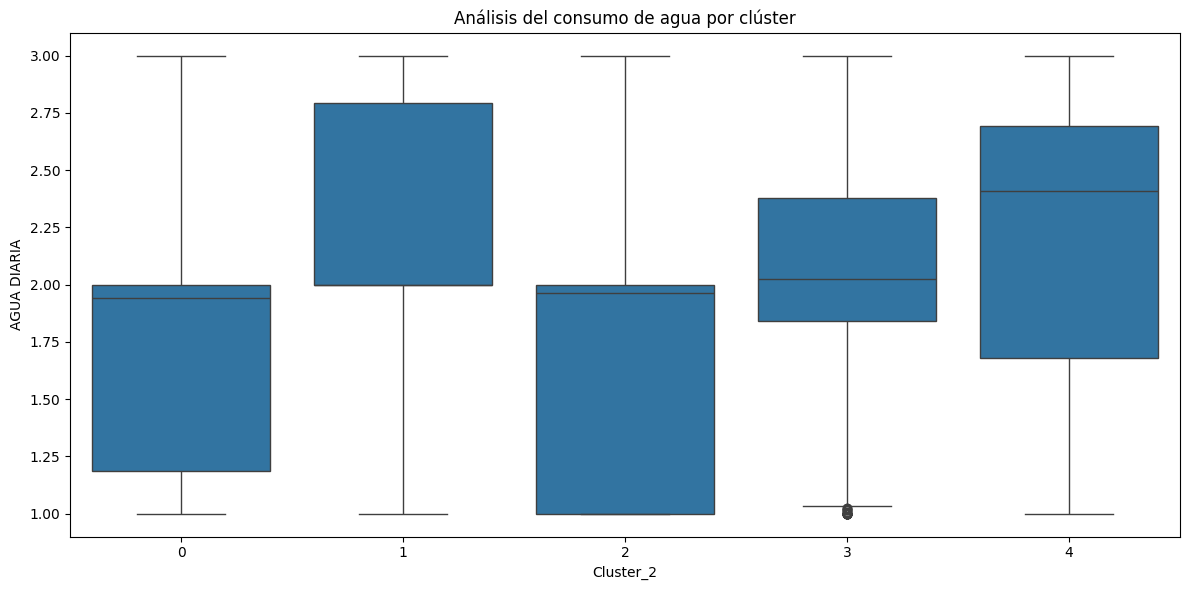

In [214]:
# Análisis del consumo dde agua

# Assuming your DataFrame is named 'df_final'
temp_agua = df_final[['Cluster_2', 'AGUA_DIARIA']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="AGUA_DIARIA", 
     data = temp_agua,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis del consumo de agua por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("AGUA DIARIA")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

Para el análisis del consumo de agua diaria se observa que los clústers 1 y 4 agrupan a las personas que más agua consumen al día (alrededor de 2.5 vasos de agua diarios). Además, en el clúster 3 se encuentran personas que consumen alrededor de 2 vasos al día. Finalmente, los clústers 0 y 2 contienen a las personas que consumen menos vasos de agua al día (entre 1 y 2 vasos al día en promedio).

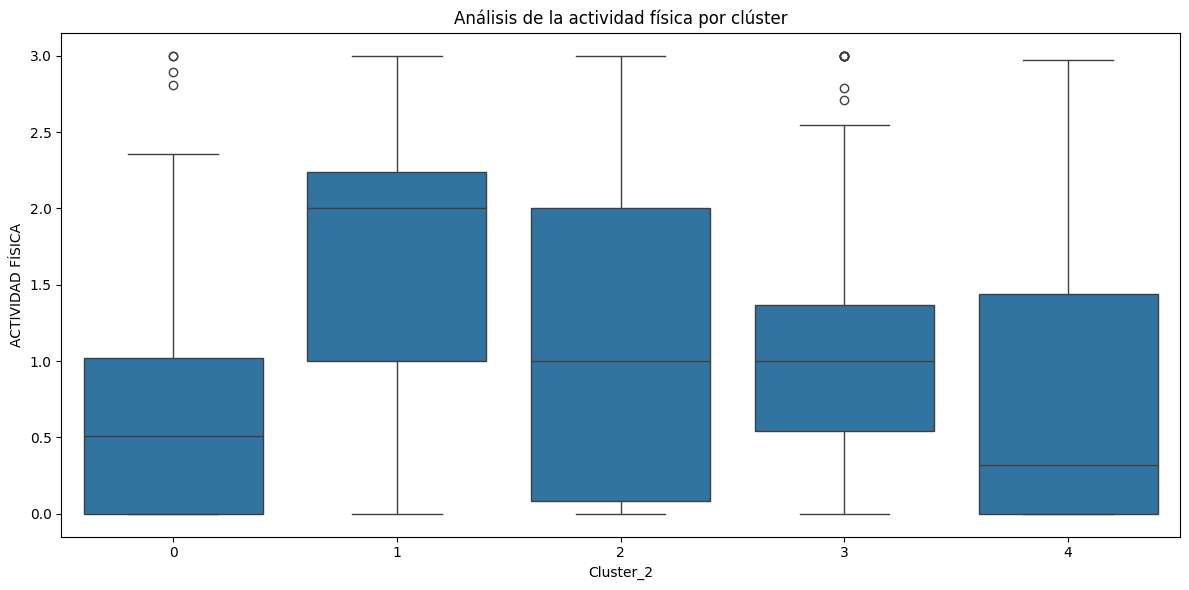

In [215]:
# Análisis de la actividad física

# Assuming your DataFrame is named 'df_final'
temp_actfi = df_final[['Cluster_2', 'ACTIVIDAD_FISICA']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="ACTIVIDAD_FISICA", 
     data = temp_actfi,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis de la actividad física por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("ACTIVIDAD FÍSICA")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

En lo que respecta a la actividad física se observa que los clústers 0 y 4 contienen a las personas que menos actividad física practican. En el caso del clúster 2 se observa que posee una caja un poco más extensa lo que permitiría pensar que posee una mezcla de personas que no realizan actividad física como personas que sí lo hacen. Finalmente el clúster 1 contiene a las personas que más actividad física practican.

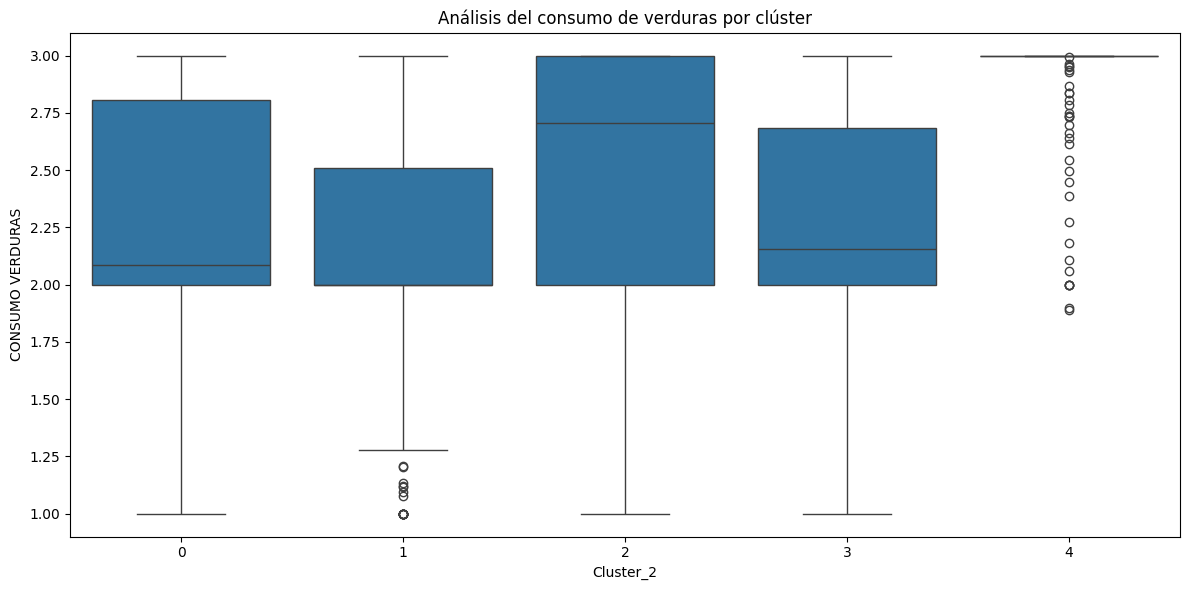

In [218]:
# Análisis del consumo de verduras

# Assuming your DataFrame is named 'df_final'
temp_verd = df_final[['Cluster_2', 'FRECUENCIA_VERDURAS']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="FRECUENCIA_VERDURAS", 
     data = temp_verd,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis del consumo de verduras por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("CONSUMO VERDURAS")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

El consumo de verduras presenta un comportamiento interesante dados los boxplots que se generan por clúster. Inicialmente se observa que el clúster 4 agrupa a las personas que consumen verduras 3 veces en promedio al día, sin embargo, contiene algunas personas que consumen un poco menos de esa cantidad. Por otro lado, los demás clústers presentan un comportamiento parecido entre ellas teniendo cajas un poco estiradas desde 2 veces en adelante, sin embargo, el clúster 1 parece contener a las personas que menos verduras consumen dados los valores extremos inferiores que presenta, y finalmente, el clúster 2 parece contener a personas que consumen verduras un poco más de 2 veces en proemdio al día.

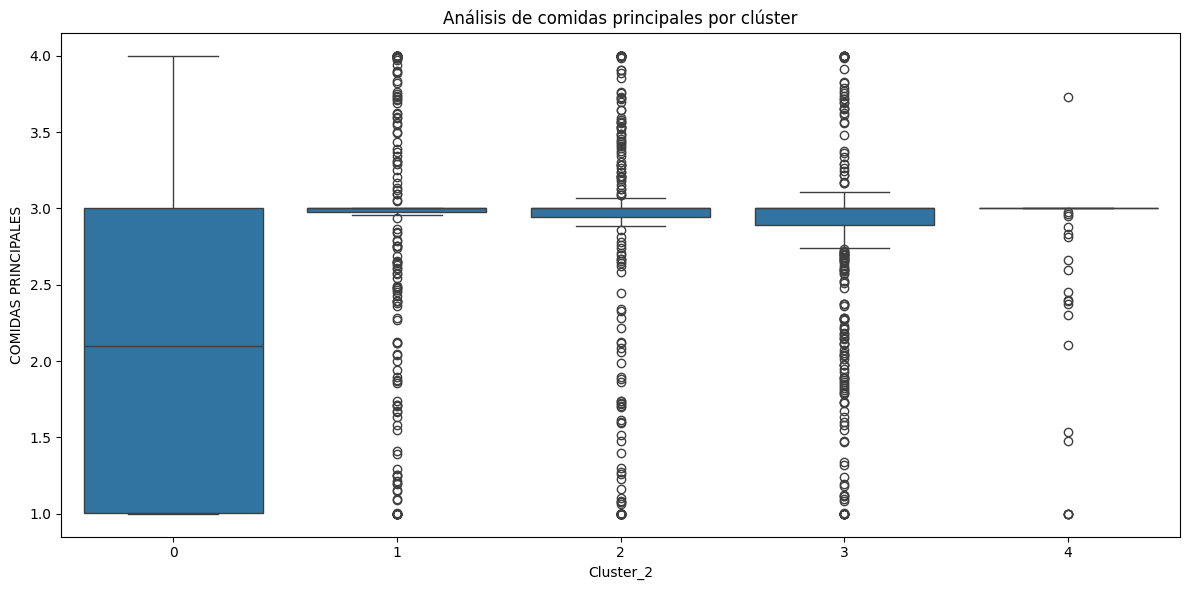

In [219]:
# Análisis de comidas principales

# Assuming your DataFrame is named 'df_final'
temp_comida = df_final[['Cluster_2', 'COMIDAS_PRINCIPALES']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="COMIDAS_PRINCIPALES", 
     data = temp_comida,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis de comidas principales por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("COMIDAS PRINCIPALES")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

Para el caso de las comidas principales por persona se observa que el clúster 4 contiene en su mayoría a personas que normlamente comen 3 comidas principales durante el día. Los clústers 1,2 y 3 presentan un comportamiento similar en el cual parece que en promedio las personas consumen 3 comidas principales al día, sin embargo, contienen una gran cantidad de datos fuera de la caja y los bigotes por lo que se puede concluir que las personas contenidas en estos clústers presnetan gran variabilidad en cuanto a este dato. Finalmente, el clúster 0 agrupa a las personas que no consumen 3 comidas principales al día (consumen entre 0 y 3 comidas principales al día con media: 2.1 comidas principales).

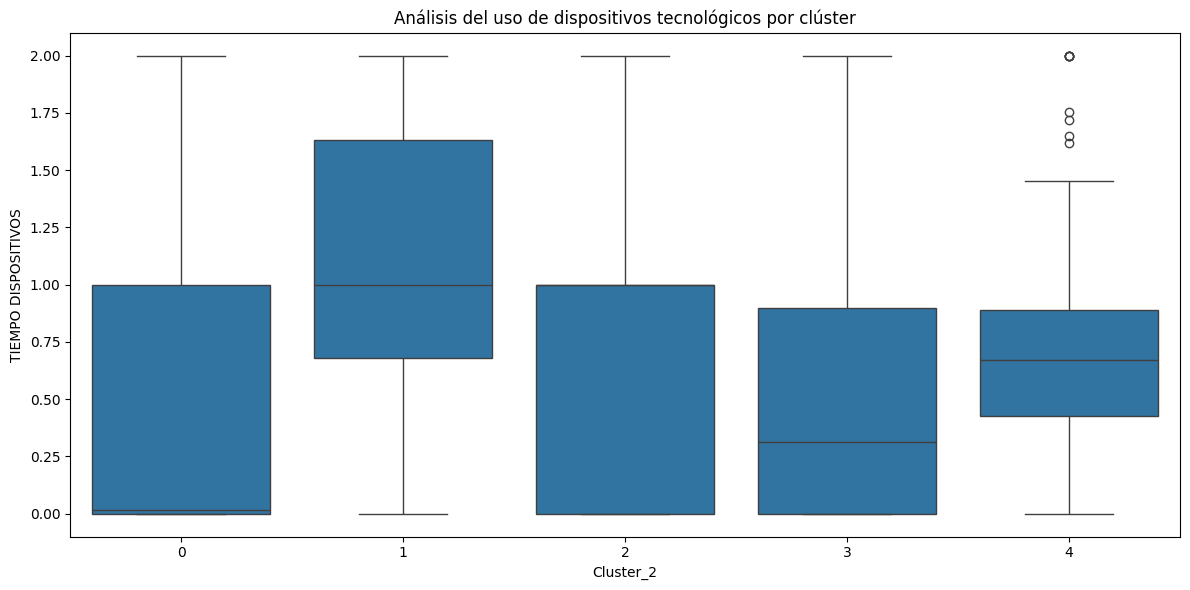

In [220]:
# Análisis del uso de dispositivos

# Assuming your DataFrame is named 'df_final'
temp_disp = df_final[['Cluster_2', 'TIEMPO_DISPOSITIVOS']]

# Create a figure and single subplot
fig, ax = plt.subplots(figsize=(12, 6))

 #Or use boxplots (uncomment these lines if preferred)
sns.boxplot(
     x="Cluster_2",
     y="TIEMPO_DISPOSITIVOS", 
     data = temp_disp,
     ax=ax
)

# Customize the plot appearance
ax.set_title("Análisis del uso de dispositivos tecnológicos por clúster")
ax.set_xlabel("Cluster_2")
ax.set_ylabel("TIEMPO DISPOSITIVOS")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

En cuanto al tiempo que pasan las personas al frente de dispositivos tecnológicos se observa que le clúster 0 agrupa en su mayoría a personas que prácticamente no utilizan dispositivos, con un comportamiento parecido al clúster 2 y 3. Por otro lado, el clúster 4 agrupa a personas que utilizan dispositivos durante un tiempo moderado. Finlamente, el clúster 1 contiene a las personas que más tiempo pasan al frente de dispositivos tecnológicos.

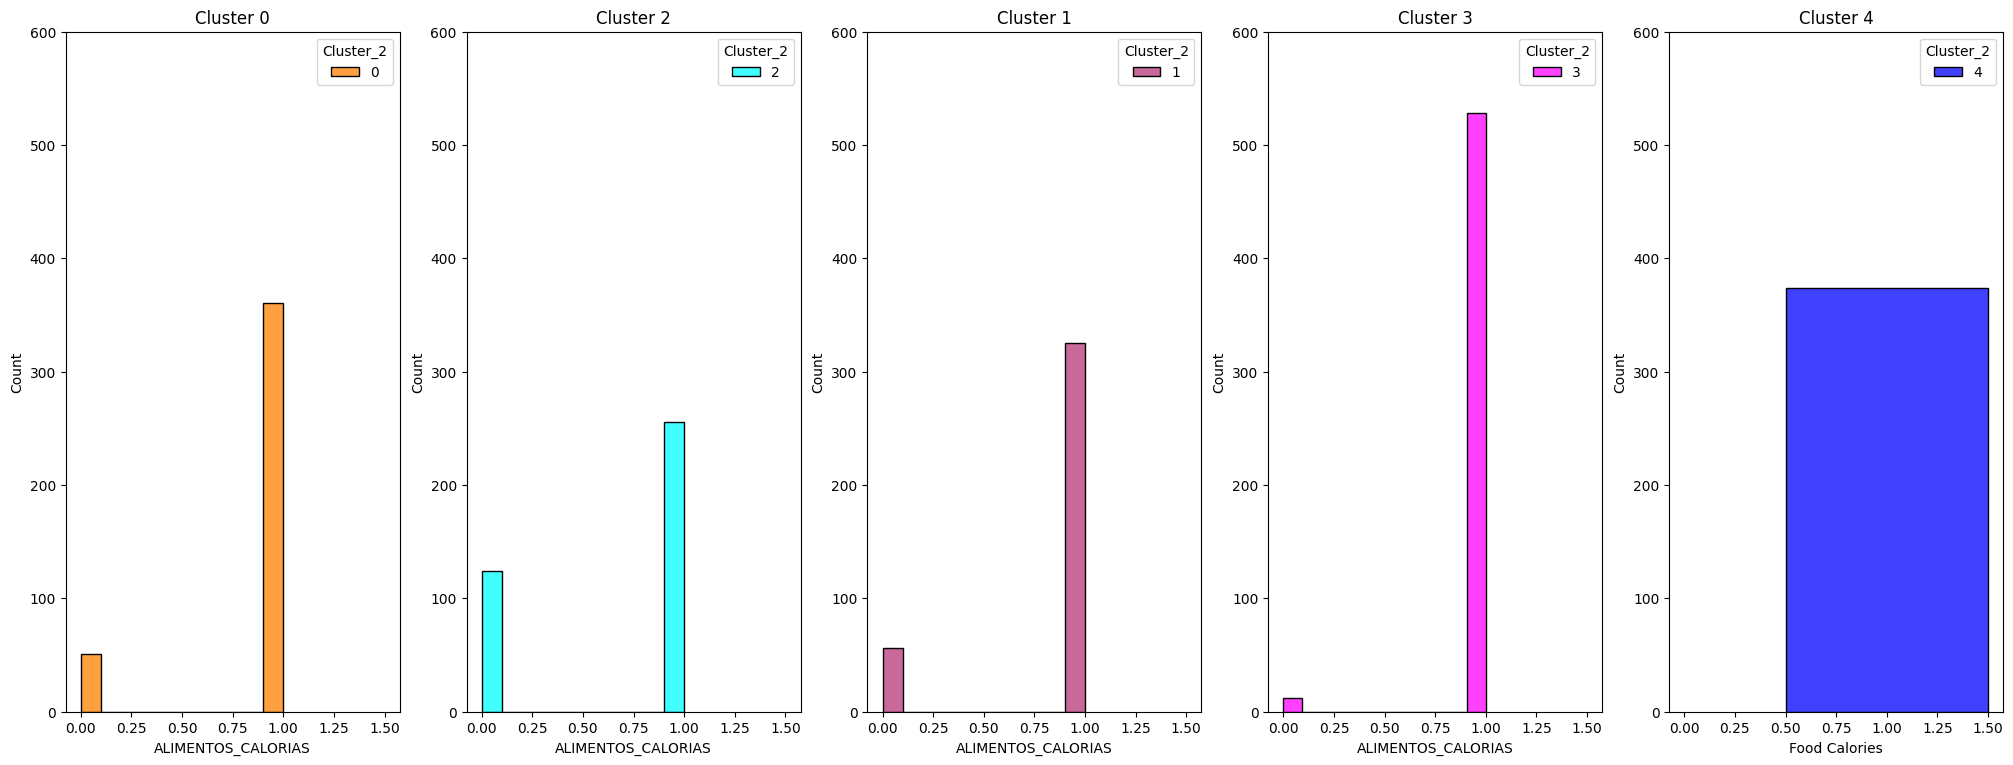

In [230]:
# Análisis del consumo de calorias

df_final['ALIMENTOS_CALORIAS'] = df_final['ALIMENTOS_CALORIAS'].astype('int32')

# Assuming your DataFrame is named 'df_final'
df_filtered = df_final.copy()  # Avoid modifying original DataFrame

# Calculate overall maximum y-axis value for consistent scaling
max_count = df_filtered.groupby('ALIMENTOS_CALORIAS')['Cluster_2'].count().max()

fig, axs = plt.subplots(ncols=5, figsize=(25, 10), sharex=True)

for i, cluster in enumerate(df_filtered['Cluster_2'].unique()):
    cluster_data = df_filtered[df_filtered['Cluster_2'] == cluster]
    sns.histplot(
        data=cluster_data,
        x="ALIMENTOS_CALORIAS",
        hue="Cluster_2",
        palette=pal[i],
        ax=axs[i],
        multiple='dodge',
        stat='count'  # Ensure count is used for y-axis
    )
    axs[i].set_title(f"Cluster {cluster}")

# Set the same y-axis limits for all subplots
for ax in axs:
    ax.set_ylim(0, 600)  # Adjust top limit slightly for spacing

plt.subplots_adjust(bottom=0.2)  # Adjust spacing to avoid overlapping with x-axis labels
plt.xlabel("Food Calories")
plt.ylabel("Count")
plt.show()

Finalmente, para el análisis del consumo de comidas altamente caloricas se observa que le clúster 4 contiene en us totalidad a personas que consumen comidas altamente caloricas. Sin embargo, los clústers 0, 1 y 3 presentan un comportamiento parecido al clúster 4 pero si contiene algunas personas que no consumen comidas altamenta caloricas. Finlamente, el clúster 2 es el que presenta un comportamiento más equitativo relativamente en el cual alredor de 120 personas no consumen comidas altamente caloricas y alrededor de 250 si lo hacen.

### **Resumen o explicación de los clústers**

**Clúster 0: Hábitos alimenticios y saludables no beneficiosos (no practican casi actividad física, no consumen agua suficiente y no suelen comer 3 comidas principales)**
- Peso promedio de 80 kg.
- Posee a las personas mayores (media: 28 años)
- Posee más mujeres que hombres
- Posee personas con la estatura más baja del estudio
- Predominan las personas que no consumen alcohol y algunas personas que lo consumen a veces
- Caracterizado por personas que a veces comen entre comidas
- Bajo consumo de agua al día
- Posee personas que menos actividad física practican
- Personas que no suelen consumir 3 comidas principales al día
- Personas que no suelen pasar mucho tiempo al frente de dispositivos tecnológicos

**Clúster 1: Jóvenes con hábitos saludables beneficiosos (no suelen consumir alchol y consumen mucha agua) pero hábitos alimenticios mejorables**
- Contiene a las personas con menor edad del estudio
- Predomina la presencia de hombres
- Personas con una altura promedio cercana a los 1.8 m.
- Predominan las personas que no consumen alcohol y algunas que lo hacen a veces
- Predominan las personas que a veces comen entre comidas
- Personas que más agua consumen al día
- Personas que más actividad física practican
- Personas que menos consumen verduras
- Contiene a las personas que más tiempo pasan al frente de dispositivos tecnológicos

**Clúster 2: Jóvenes bajas y livianas con alto consumo de alimentos entre comidas y bajo consumo de agua**
- Contiene a las personas más livianas del estudio (menor peso)
- Personas jóvenes
- Predominan las mujeres
- Personas con estatura baja
- Predominan las personas que consumen alcohol a veces y algunas que no lo consumen
- Este clúster contiene a la mayoría de personas que comen entre comidas frecuentemente y siempre, también algunas personas que lo hacen a veces (casi ninguna no lo hace)
- Bajo consumo de agua
- Consumo de verduras levemente superior
- Poco tiempo al frente de dispositivos

**Clúster 3: Hombres pesados con una alta estatura que presentan malos hábitos alimenticios y consumo de alcohol considerable**
- Personas levemente pesadas (media: 103 kg.)
- Contiene personas con mayor edad del estudio
- Prácticamente sólo posee hombres (alrededor del 98%)
- Personas más altas del estudio
- Práticamente todas las personas consumen alcohol a veces
- Prácticamente todas las personas a veces comen entre comidas
- Alrededor del 95% de las personas consumen comidas altamente caloricas

**Clúster 4: Mujeres pesadas con malos hábitos alimenticios y saludables pero que consumen agua y tienen 3 comidas principales al día**
- Contiene a las personas más pesadas del estudio (media: 114 kg.)
- Prácticamente todas las personas son mujeres
- Práctcamente todas consumen alcohol a veces
- Todas comen entre comidas a veces
- Alto consumo de agua
- Es el clúster que contiene a las personas que menos actividad física practican
- Personas con mayor consumo de verduras al día
- Personas que normalmente consumen 3 comidas principales al día
- Todas las personas consumen comidas altamente caloricas

## **Gráfico de K-means con PCA utilizando los 3 componentes principales**

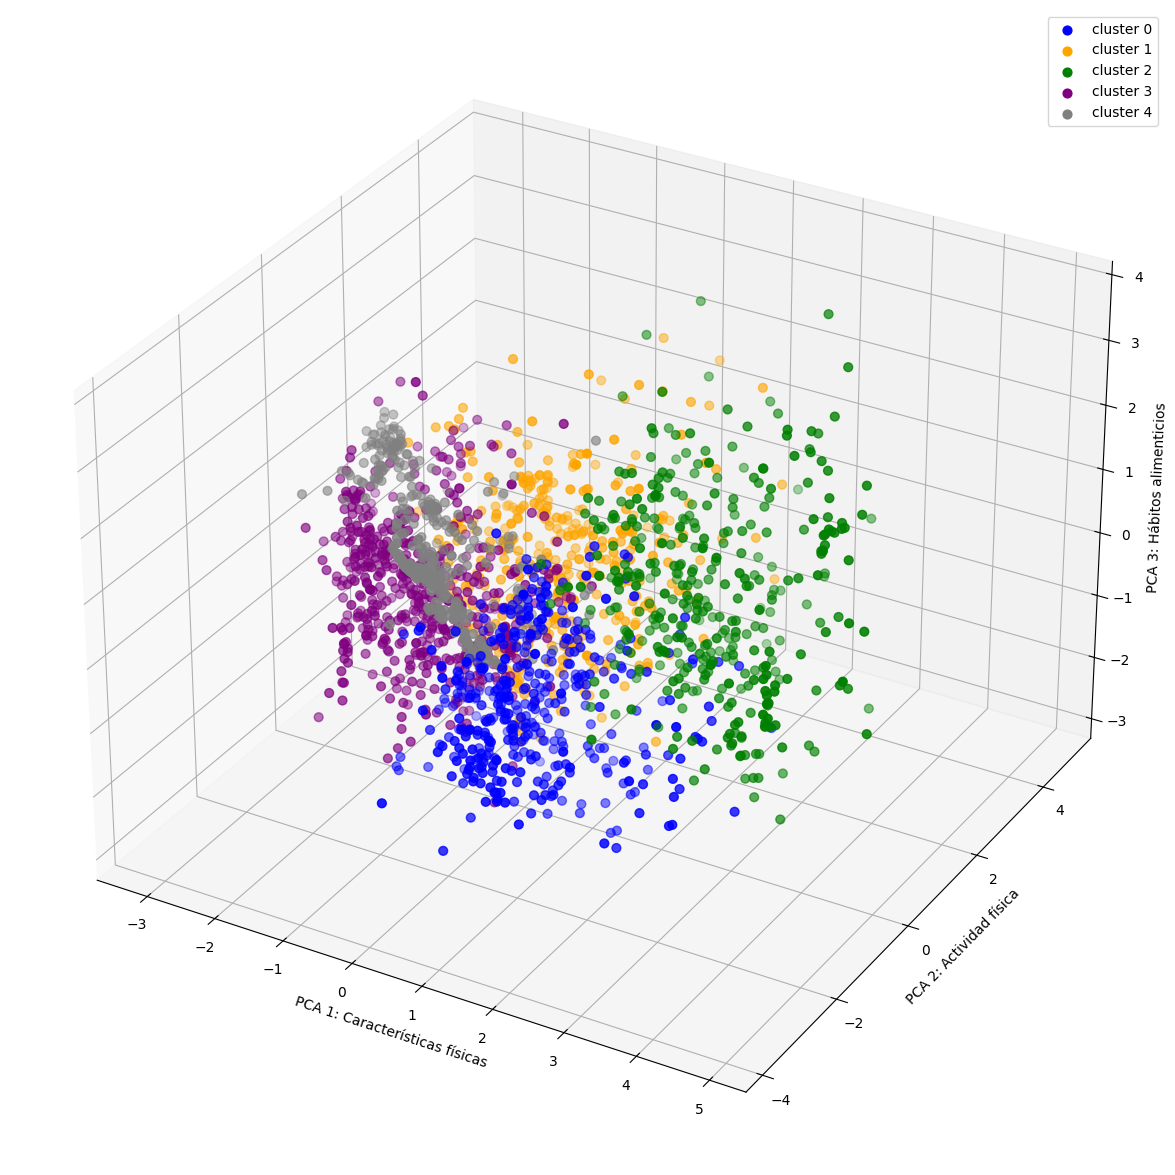

In [260]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_pca[Cluster_2 == 0,0],X1_pca[Cluster_2 == 0,1],X1_pca[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X1_pca[Cluster_2 == 1,0],X1_pca[Cluster_2 == 1,1],X1_pca[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X1_pca[Cluster_2 == 2,0],X1_pca[Cluster_2 == 2,1],X1_pca[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X1_pca[Cluster_2 == 3,0],X1_pca[Cluster_2 == 3,1],X1_pca[Cluster_2 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X1_pca[Cluster_2 == 4,0],X1_pca[Cluster_2 == 4,1],X1_pca[Cluster_2 == 4,2], s = 40 , color = 'gray', label = "cluster 4")
ax.set_xlabel('PCA 1: Características físicas')
ax.set_ylabel('PCA 2: Actividad física')
ax.set_zlabel('PCA 3: Hábitos alimenticios')
ax.legend()
#ax.view_init(elev=-270, azim=360)
plt.show()

**Componente 0:** Dentro de este componente se observa que las variables que mayor peso tienen son el género (relación directa), el peso y la altura (relación inversa), por lo que se podría entender este componente como el que tiene en cuenta las características físicas particulares de cada persona. 

**Componente 1:** Este componente tiene a la actividad física (relación directa) y a la edad (relación inversa) como las variables que mayor peso obtienen dentro del mismo, por lo que se puede asociar este componente al desarrollo de la persona a través de la práctica de actividad física.

**Componente 2:** Dentro de este componente se observa que la frecuencia con la que comen verduras y el número de comidas principales de las personas al día (relación directa) obtienen un peso realmente considerable para la explicabilidad de este. Por ende, este componente se puede clasificar como el que agrupa los hábitos alimenticios de las personas.

Inicialmente, cabe recordar que los 3 componentes principales explican alrededor del 40% de la varianza por lo que la respresnetación gráfica nos permite observar el comportamiento de la clusterización pero las cocnlusiones como tal no generan tanta confianza.

Ahora, en cuanto al gráfico como tal se observa que algunos clústers presnetan ruído considerable que no permite obtener agrupaciones tan precisas, y además, algunos clústers se traslapan. Sin embargo, se observan comportamientos interesantes como en el caso del clúster 0: azul (personas con malos hábitos alimenticios y saludables) donde se observa que entre más malos sean sus hábitos alimenticios, menos actividad física práctica. Así mismo, el clúster 2: verde (donde predominan las mujeres bajas y livianas) muestra que entre mayor sea su valor (1: mujeres - 0:hombres) en el PCA 1 (caracterísiticas físicas) mejores hábitos alimenticios.

Por otro lado, el clúster 1: amarillo (que se caracteriza por tener jóvenes con hábitos saludables beneficiosos) deja ver levemente que los hombres (valores menores de PCA 1) son los que más suelen realizar actividas física.

*Nota: para poder concluir lo anterior se hizo uso del comando ax.view_init() para poder ir girando el gráfico de modo que permitiera identificar la posición de los clústers en 3 dimensiones*